In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Libraries

import os
import time
import keras
import shutil
import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from random import randint
from IPython import display
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Input,Conv2D,LeakyReLU,Flatten,Dropout, Dense,Reshape,Conv2DTranspose,BatchNormalization,Activation,UpSampling2D

In [ ]:
# Collect the data using ImageDataGenerator
unlabeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)
unlabeled_datagen = unlabeled_data_gen.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection",
                                                           target_size=(32,32),classes=['unlabeled'],batch_size=256)

Found 7028 images belonging to 1 classes.


In [ ]:
# Function for Discriminator and Generator
def discriminator():

  # Start adding layers 
  # if the size of the img decrease, channels(=64) increases. Kernal size = 4, means 4x4 matrix
  # alpha = 2, #input channels = 3, after passing conv2d(filters/channel/kernal = 64) -- after leakyReLU - half pixels
  # BatchNormalization - To normalize

  dis = Sequential(name="Discriminator")
  
  dis.add(Conv2D(filters=64,kernel_size=4,strides=2,padding="same",input_shape=(32,32,3),use_bias=False))
  dis.add(LeakyReLU(alpha=0.2)) 

  dis.add(Conv2D(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=256,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Flatten())                     # Convert the resultant array into a column vector
  dis.add(Dropout(0.3))                  # Work as a Regularization to prevent over fitting

  dis.add(Dense(units=1,activation="sigmoid"))    # Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer

  return dis

def generator():

  noise_shape = 100                      # Generator will take 100 Dimentional Noise Vector and generate fake imgs of (32,32,3)
  gen = Sequential(name="Generator")

  gen.add(Input(shape=(noise_shape,)))   
  gen.add(Dense(units=4*4*100))          # Creating a Dense layer of 1600 Neurons
  gen.add(Reshape((4,4,100)))            # Perform upsampling by De-convolution layer (Transposed Convolution)

  gen.add(Conv2DTranspose(filters=256,kernel_size=4,strides=1,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=64,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=3,kernel_size=4,strides=2,padding="same",activation="tanh",use_bias=False))
  
  return gen

In [ ]:
D = discriminator()
D.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        3072      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131072    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524288    
                                                     

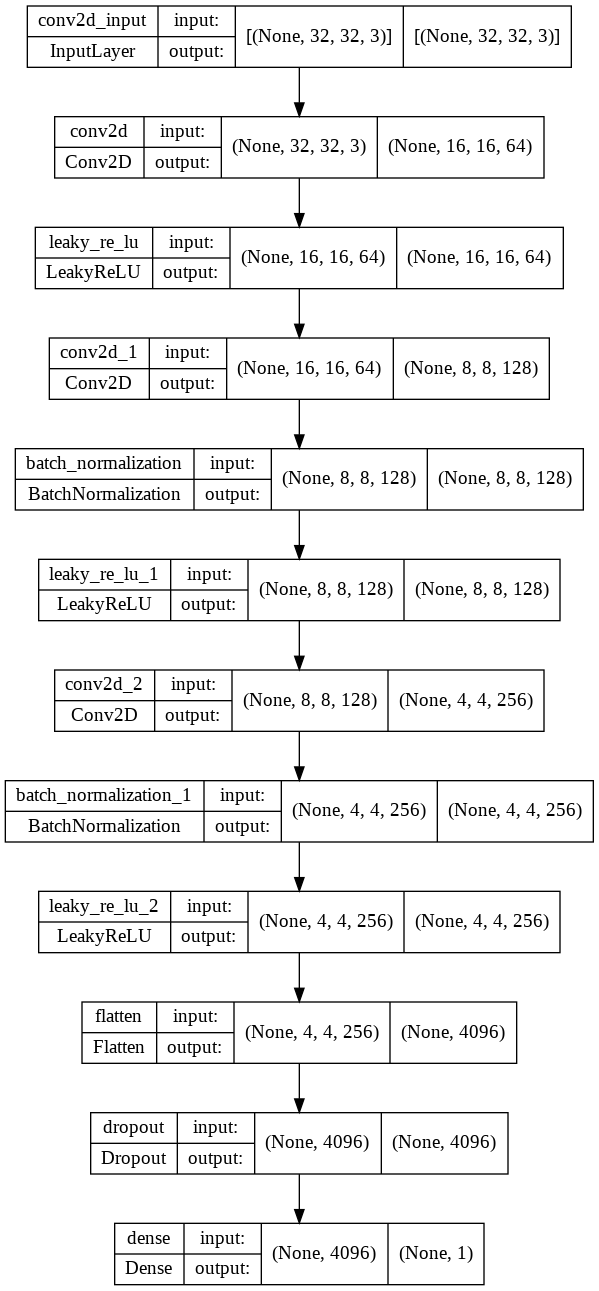

In [ ]:
tf.keras.utils.plot_model(model=D,show_shapes=True)

In [ ]:
G = generator()
G.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        409600    
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 4, 4, 256)        1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        52

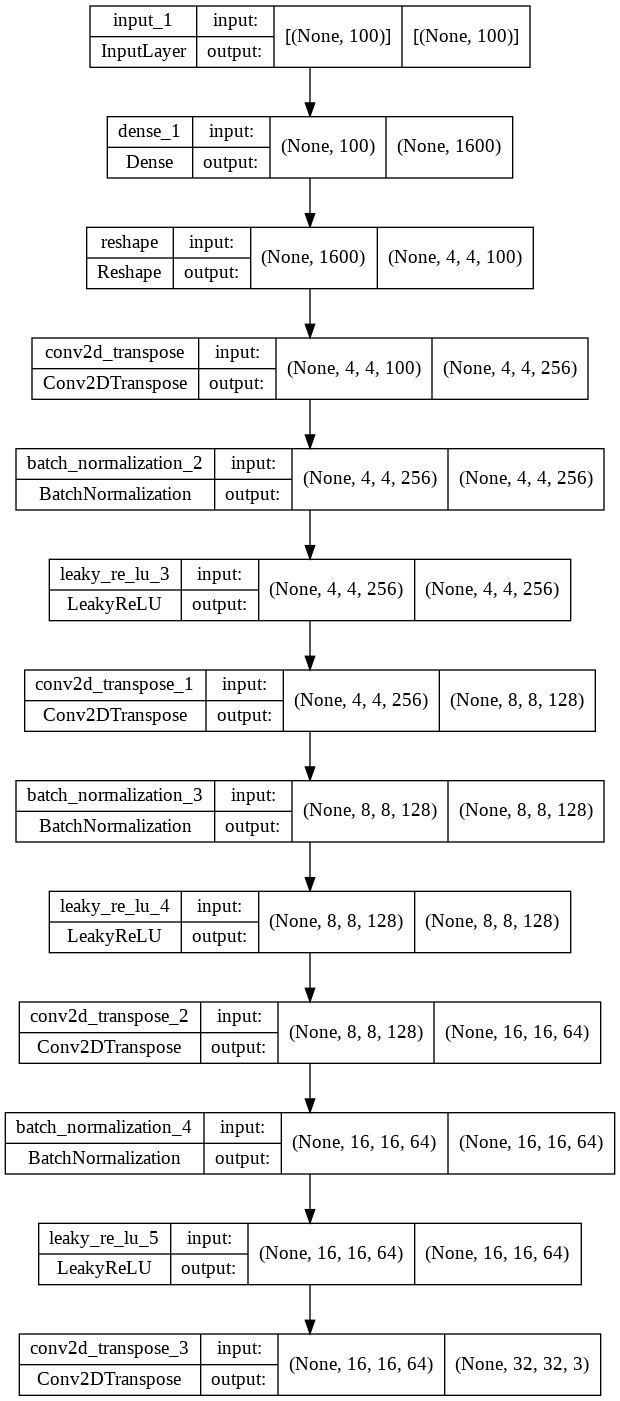

In [ ]:
tf.keras.utils.plot_model(model=G,show_shapes=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


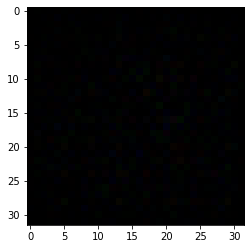

In [ ]:
random_noise = tf.random.normal(shape=(1,100))      # Creating a random noise
generated_image = G(random_noise,training=False)    # Output image generated from random noise
plt.imshow(generated_image[0,:,:,:])

In [ ]:
posterior = D(generated_image)          # Discriminator will give Posterior Probability as output
print(posterior)

tf.Tensor([[0.49956623]], shape=(1, 1), dtype=float32)


In [ ]:
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)         # Object for Cross Entropy Loss

In [ ]:
# Function to calculate Discriminator Loss
def D_loss(real_imgs_preds,fake_imgs_preds):
  real_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(real_imgs_preds)) + tf.ones_like(real_imgs_preds)    # Adding noise to the labels 
  fake_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(fake_imgs_preds)) + tf.zeros_like(fake_imgs_preds)

  real_imgs_bce_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_bce_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_bce_loss + fake_imgs_bce_loss

  return total_loss

# Function to calculate Generator Loss
def G_loss(fake_imgs_preds):
  fake_imgs_labels = tf.ones_like(fake_imgs_preds)

  return bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

In [ ]:
GAN_epochs = 100      # Number of epochs in total
noise_shape = 100     # Input
batch_size = 256      # Size of one batch that will pass through Generator

In [ ]:
GENERATE_RES = 1                      # Generation resolution factor 
                                      # (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES   # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/MyDrive/MelanomaDetection/unlabeled'
EPOCHS = 100
BATCH_SIZE = 256
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 32px square images.


In [ ]:
# Steps for Normalization
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  # print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/drive/MyDrive/MelanomaDetection/unlabeled/training_data_32_32.npy
Loading training images...


100%|██████████| 7028/7028 [01:39<00:00, 70.30it/s]  


Saving training image binary...


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(batch_size)
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

In [ ]:
D_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
G_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
GAN_checkpoint_dir = "/content/drive/MyDrive/GAN_training_checkpoints"
GAN_checkpoint_prefix = os.path.join(GAN_checkpoint_dir,"ckpt")
GAN_checkpoint = tf.train.Checkpoint(optimizer=[D_optimizer,G_optimizer],model=[D,G])

In [ ]:
# @tf.function
# def training_step(real_imgs_mini_batch):

#   G.trainable = False
#   noise = tf.random.normal(shape=(batch_size,noise_shape))
#   generated_imgs_mini_batch = G(noise,training=False)

#   D.trainable = True

#   with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

#     real_imgs_preds = D(real_imgs_mini_batch,training=True)
#     fake_imgs_preds = D(generated_imgs_mini_batch,training=True)

#     disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)

#     gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)
#     D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables))

#     D.trainable = False
#     G.trainable = True

#     #noise = tf.random.normal(shape=(batch_size,noise_shape))
#     generated_imgs_mini_batch = G(noise,training=True)

#     fake_imgs_preds = D(generated_imgs_mini_batch,training=False)

#     gen_loss = G_loss(fake_imgs_preds)

#     gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)
#     G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))

In [ ]:
constant_noise = tf.random.normal(shape=(16,noise_shape))

In [ ]:
def generate_and_save_images(generator_model,epoch,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(7,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(7,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.savefig("Images_at_Epoch_{:04d}.png".format(epoch))
  plt.show()

In [ ]:
real_imgs_path = "/content/drive/MyDrive/MelanomaDetection/unlabeled"

Main function to train the GAN network

In [ ]:
def train_gan(real_imgs_datagen,total_epochs):
  constant_noise = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,SEED_SIZE))
  for epoch in range(total_epochs):

    time_step = 1

    for image_batch in real_imgs_datagen:
     
      # print(image_batch.shape)
      print("Training GAN at Time Step {} of Epoch {}".format(time_step,epoch+1))

      G.trainable = False
      
      print('1')

      D.trainable = True

      with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        
        noise = tf.random.normal([BATCH_SIZE, SEED_SIZE])
        generated_imgs_mini_batch = G(noise,training=False)
       

        real_imgs_preds = D(image_batch,training=True)
        fake_imgs_preds = D(generated_imgs_mini_batch,training=True)

        disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)
        print(f'************ for time_step {time_step}, discriminator loss is {disc_loss} ***********')

        gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)         # Calculate Gradients for disc_loss
        D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables))       # Backpropogation
                         
        D.trainable = False
        G.trainable = True

        gen_loss = G_loss(fake_imgs_preds)
        print(f'******** for time_step {time_step}, generator loss is {gen_loss} ***********')

        gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)            # Calculate Gradients for gen_loss
        G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))        # Backpropogation


      if time_step > len(os.listdir(real_imgs_path))//batch_size:                       # 27 epochs
        break

      time_step = time_step + 1

    generate_and_save_images(generator_model=G,epoch=epoch+1,test_input=constant_noise)

    if (epoch + 1) % 5 == 0:
      GAN_checkpoint.save(file_prefix=GAN_checkpoint_prefix)

  generate_and_save_images(generator_model=G,epoch=total_epochs,test_input=constant_noise) # Generate the image - 1 epoch complete

Training GAN at Time Step 1 of Epoch 1
1


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


************ for time_step 1, discriminator loss is 1.5325536727905273 ***********
******** for time_step 1, generator loss is 0.7558674216270447 ***********
Training GAN at Time Step 2 of Epoch 1
1
************ for time_step 2, discriminator loss is 1.0788921117782593 ***********
******** for time_step 2, generator loss is 0.5499115586280823 ***********
Training GAN at Time Step 3 of Epoch 1
1
************ for time_step 3, discriminator loss is 0.9902613759040833 ***********
******** for time_step 3, generator loss is 0.5539140701293945 ***********
Training GAN at Time Step 4 of Epoch 1
1
************ for time_step 4, discriminator loss is 0.7171562910079956 ***********
******** for time_step 4, generator loss is 0.7425193786621094 ***********
Training GAN at Time Step 5 of Epoch 1
1
************ for time_step 5, discriminator loss is 0.5794827938079834 ***********
******** for time_step 5, generator loss is 0.9210172891616821 ***********
Training GAN at Time Step 6 of Epoch 1
1
*****

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


******** for time_step 28, generator loss is 1.9926855564117432 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

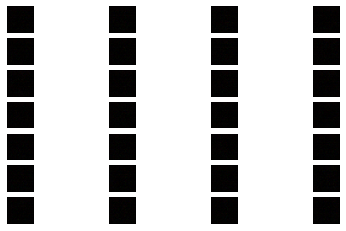

Training GAN at Time Step 1 of Epoch 2
1
************ for time_step 1, discriminator loss is 0.12689630687236786 ***********
******** for time_step 1, generator loss is 1.8984642028808594 ***********
Training GAN at Time Step 2 of Epoch 2
1
************ for time_step 2, discriminator loss is 0.16573664546012878 ***********
******** for time_step 2, generator loss is 1.9584534168243408 ***********
Training GAN at Time Step 3 of Epoch 2
1
************ for time_step 3, discriminator loss is 0.1217847466468811 ***********
******** for time_step 3, generator loss is 2.0778427124023438 ***********
Training GAN at Time Step 4 of Epoch 2
1
************ for time_step 4, discriminator loss is 0.16378724575042725 ***********
******** for time_step 4, generator loss is 1.992098093032837 ***********
Training GAN at Time Step 5 of Epoch 2
1
************ for time_step 5, discriminator loss is 0.13542497158050537 ***********
******** for time_step 5, generator loss is 1.995347261428833 ***********
Tra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

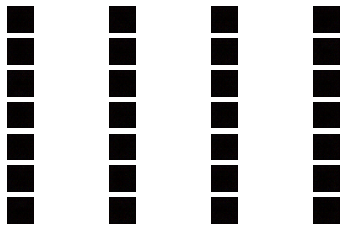

Training GAN at Time Step 1 of Epoch 3
1
************ for time_step 1, discriminator loss is -0.03853403031826019 ***********
******** for time_step 1, generator loss is 2.922614097595215 ***********
Training GAN at Time Step 2 of Epoch 3
1
************ for time_step 2, discriminator loss is -0.00805547833442688 ***********
******** for time_step 2, generator loss is 2.6683859825134277 ***********
Training GAN at Time Step 3 of Epoch 3
1
************ for time_step 3, discriminator loss is -0.05488702654838562 ***********
******** for time_step 3, generator loss is 2.9250946044921875 ***********
Training GAN at Time Step 4 of Epoch 3
1
************ for time_step 4, discriminator loss is -0.036424681544303894 ***********
******** for time_step 4, generator loss is 3.034280776977539 ***********
Training GAN at Time Step 5 of Epoch 3
1
************ for time_step 5, discriminator loss is -0.044697970151901245 ***********
******** for time_step 5, generator loss is 2.7866106033325195 *******

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

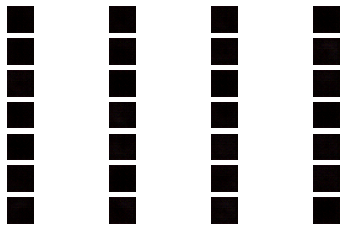

Training GAN at Time Step 1 of Epoch 4
1
************ for time_step 1, discriminator loss is -0.10345858335494995 ***********
******** for time_step 1, generator loss is 3.1524927616119385 ***********
Training GAN at Time Step 2 of Epoch 4
1
************ for time_step 2, discriminator loss is -0.11509951949119568 ***********
******** for time_step 2, generator loss is 3.088054656982422 ***********
Training GAN at Time Step 3 of Epoch 4
1
************ for time_step 3, discriminator loss is -0.12384027242660522 ***********
******** for time_step 3, generator loss is 2.9926865100860596 ***********
Training GAN at Time Step 4 of Epoch 4
1
************ for time_step 4, discriminator loss is -0.14518827199935913 ***********
******** for time_step 4, generator loss is 3.2333929538726807 ***********
Training GAN at Time Step 5 of Epoch 4
1
************ for time_step 5, discriminator loss is -0.141154944896698 ***********
******** for time_step 5, generator loss is 3.2464678287506104 **********

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

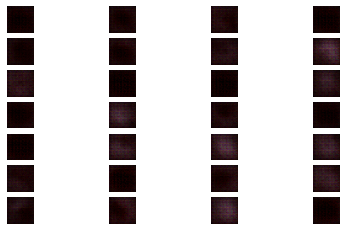

Training GAN at Time Step 1 of Epoch 5
1
************ for time_step 1, discriminator loss is -0.07199665904045105 ***********
******** for time_step 1, generator loss is 1.912801742553711 ***********
Training GAN at Time Step 2 of Epoch 5
1
************ for time_step 2, discriminator loss is -0.0011646449565887451 ***********
******** for time_step 2, generator loss is 8.029940605163574 ***********
Training GAN at Time Step 3 of Epoch 5
1
************ for time_step 3, discriminator loss is -0.0591551810503006 ***********
******** for time_step 3, generator loss is 8.074006080627441 ***********
Training GAN at Time Step 4 of Epoch 5
1
************ for time_step 4, discriminator loss is -0.13808372616767883 ***********
******** for time_step 4, generator loss is 6.241958141326904 ***********
Training GAN at Time Step 5 of Epoch 5
1
************ for time_step 5, discriminator loss is -0.22755166888237 ***********
******** for time_step 5, generator loss is 4.112351417541504 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 5
1
************ for time_step 28, discriminator loss is 0.10977061837911606 ***********
******** for time_step 28, generator loss is 3.5030782222747803 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

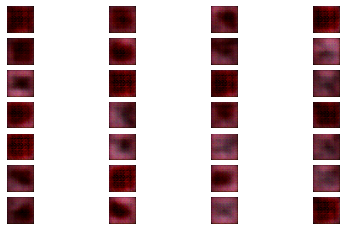

Training GAN at Time Step 1 of Epoch 6
1
************ for time_step 1, discriminator loss is 0.0908462256193161 ***********
******** for time_step 1, generator loss is 2.7791504859924316 ***********
Training GAN at Time Step 2 of Epoch 6
1
************ for time_step 2, discriminator loss is 0.14446711540222168 ***********
******** for time_step 2, generator loss is 2.4366767406463623 ***********
Training GAN at Time Step 3 of Epoch 6
1
************ for time_step 3, discriminator loss is 0.12829074263572693 ***********
******** for time_step 3, generator loss is 3.0936942100524902 ***********
Training GAN at Time Step 4 of Epoch 6
1
************ for time_step 4, discriminator loss is 0.11096324026584625 ***********
******** for time_step 4, generator loss is 2.40867018699646 ***********
Training GAN at Time Step 5 of Epoch 6
1
************ for time_step 5, discriminator loss is 0.12073825299739838 ***********
******** for time_step 5, generator loss is 4.072474002838135 ***********
Trai

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

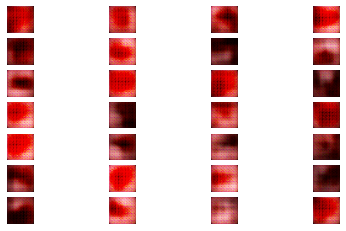

Training GAN at Time Step 1 of Epoch 7
1
************ for time_step 1, discriminator loss is 0.4884006977081299 ***********
******** for time_step 1, generator loss is 1.2556456327438354 ***********
Training GAN at Time Step 2 of Epoch 7
1
************ for time_step 2, discriminator loss is 1.0680017471313477 ***********
******** for time_step 2, generator loss is 5.370141983032227 ***********
Training GAN at Time Step 3 of Epoch 7
1
************ for time_step 3, discriminator loss is 1.1744886636734009 ***********
******** for time_step 3, generator loss is 0.6512848138809204 ***********
Training GAN at Time Step 4 of Epoch 7
1
************ for time_step 4, discriminator loss is 0.8966202139854431 ***********
******** for time_step 4, generator loss is 5.125923156738281 ***********
Training GAN at Time Step 5 of Epoch 7
1
************ for time_step 5, discriminator loss is 0.23268944025039673 ***********
******** for time_step 5, generator loss is 2.5398290157318115 ***********
Traini

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

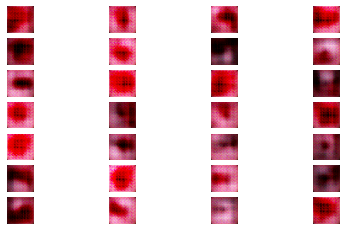

Training GAN at Time Step 1 of Epoch 8
1
************ for time_step 1, discriminator loss is 0.3706686496734619 ***********
******** for time_step 1, generator loss is 2.0249741077423096 ***********
Training GAN at Time Step 2 of Epoch 8
1
************ for time_step 2, discriminator loss is 0.6461992859840393 ***********
******** for time_step 2, generator loss is 1.0873721837997437 ***********
Training GAN at Time Step 3 of Epoch 8
1
************ for time_step 3, discriminator loss is 0.3171690106391907 ***********
******** for time_step 3, generator loss is 3.531205177307129 ***********
Training GAN at Time Step 4 of Epoch 8
1
************ for time_step 4, discriminator loss is 0.3546152710914612 ***********
******** for time_step 4, generator loss is 3.6566290855407715 ***********
Training GAN at Time Step 5 of Epoch 8
1
************ for time_step 5, discriminator loss is 0.2933919429779053 ***********
******** for time_step 5, generator loss is 2.076111316680908 ***********
Trainin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 8
1
************ for time_step 28, discriminator loss is 0.3378669023513794 ***********
******** for time_step 28, generator loss is 2.276212215423584 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

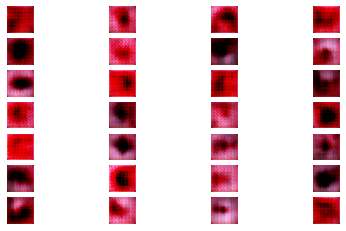

Training GAN at Time Step 1 of Epoch 9
1
************ for time_step 1, discriminator loss is 0.40790849924087524 ***********
******** for time_step 1, generator loss is 1.726104974746704 ***********
Training GAN at Time Step 2 of Epoch 9
1
************ for time_step 2, discriminator loss is 0.5160671472549438 ***********
******** for time_step 2, generator loss is 2.163022041320801 ***********
Training GAN at Time Step 3 of Epoch 9
1
************ for time_step 3, discriminator loss is 0.609520435333252 ***********
******** for time_step 3, generator loss is 1.260467767715454 ***********
Training GAN at Time Step 4 of Epoch 9
1
************ for time_step 4, discriminator loss is 0.68206387758255 ***********
******** for time_step 4, generator loss is 3.1857829093933105 ***********
Training GAN at Time Step 5 of Epoch 9
1
************ for time_step 5, discriminator loss is 1.0335417985916138 ***********
******** for time_step 5, generator loss is 0.658202052116394 ***********
Training GA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 9
1
************ for time_step 28, discriminator loss is 0.48543792963027954 ***********
******** for time_step 28, generator loss is 2.9220099449157715 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

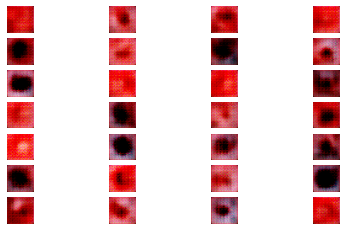

Training GAN at Time Step 1 of Epoch 10
1
************ for time_step 1, discriminator loss is 0.6182122826576233 ***********
******** for time_step 1, generator loss is 1.1461100578308105 ***********
Training GAN at Time Step 2 of Epoch 10
1
************ for time_step 2, discriminator loss is 0.8707647323608398 ***********
******** for time_step 2, generator loss is 3.788836717605591 ***********
Training GAN at Time Step 3 of Epoch 10
1
************ for time_step 3, discriminator loss is 1.4406614303588867 ***********
******** for time_step 3, generator loss is 0.48819658160209656 ***********
Training GAN at Time Step 4 of Epoch 10
1
************ for time_step 4, discriminator loss is 1.1033141613006592 ***********
******** for time_step 4, generator loss is 5.31935977935791 ***********
Training GAN at Time Step 5 of Epoch 10
1
************ for time_step 5, discriminator loss is 0.3542618155479431 ***********
******** for time_step 5, generator loss is 2.2329413890838623 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 10
1
************ for time_step 28, discriminator loss is 0.5973213911056519 ***********
******** for time_step 28, generator loss is 1.7550442218780518 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

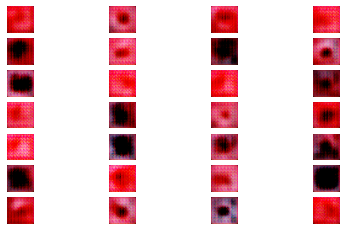

Training GAN at Time Step 1 of Epoch 11
1
************ for time_step 1, discriminator loss is 0.6821250915527344 ***********
******** for time_step 1, generator loss is 1.769037127494812 ***********
Training GAN at Time Step 2 of Epoch 11
1
************ for time_step 2, discriminator loss is 0.6142351627349854 ***********
******** for time_step 2, generator loss is 1.6147137880325317 ***********
Training GAN at Time Step 3 of Epoch 11
1
************ for time_step 3, discriminator loss is 0.5051942467689514 ***********
******** for time_step 3, generator loss is 2.0027687549591064 ***********
Training GAN at Time Step 4 of Epoch 11
1
************ for time_step 4, discriminator loss is 0.43914687633514404 ***********
******** for time_step 4, generator loss is 1.8425840139389038 ***********
Training GAN at Time Step 5 of Epoch 11
1
************ for time_step 5, discriminator loss is 0.37784725427627563 ***********
******** for time_step 5, generator loss is 2.219085216522217 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

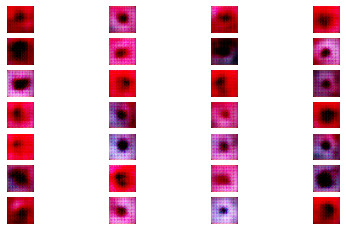

Training GAN at Time Step 1 of Epoch 12
1
************ for time_step 1, discriminator loss is 0.3613109886646271 ***********
******** for time_step 1, generator loss is 2.1424782276153564 ***********
Training GAN at Time Step 2 of Epoch 12
1
************ for time_step 2, discriminator loss is 0.3856503963470459 ***********
******** for time_step 2, generator loss is 2.2513890266418457 ***********
Training GAN at Time Step 3 of Epoch 12
1
************ for time_step 3, discriminator loss is 0.38585516810417175 ***********
******** for time_step 3, generator loss is 1.6851105690002441 ***********
Training GAN at Time Step 4 of Epoch 12
1
************ for time_step 4, discriminator loss is 0.3739420473575592 ***********
******** for time_step 4, generator loss is 2.3832058906555176 ***********
Training GAN at Time Step 5 of Epoch 12
1
************ for time_step 5, discriminator loss is 0.37485837936401367 ***********
******** for time_step 5, generator loss is 1.9407682418823242 **********

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


******** for time_step 28, generator loss is 0.46263957023620605 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

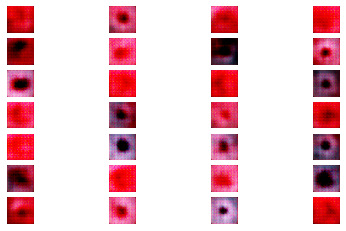

Training GAN at Time Step 1 of Epoch 13
1
************ for time_step 1, discriminator loss is 1.4174777269363403 ***********
******** for time_step 1, generator loss is 4.968201637268066 ***********
Training GAN at Time Step 2 of Epoch 13
1
************ for time_step 2, discriminator loss is 0.8396217823028564 ***********
******** for time_step 2, generator loss is 0.8921005129814148 ***********
Training GAN at Time Step 3 of Epoch 13
1
************ for time_step 3, discriminator loss is 0.4267902970314026 ***********
******** for time_step 3, generator loss is 2.341975450515747 ***********
Training GAN at Time Step 4 of Epoch 13
1
************ for time_step 4, discriminator loss is 0.42747724056243896 ***********
******** for time_step 4, generator loss is 2.8962557315826416 ***********
Training GAN at Time Step 5 of Epoch 13
1
************ for time_step 5, discriminator loss is 0.728532612323761 ***********
******** for time_step 5, generator loss is 1.0374046564102173 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

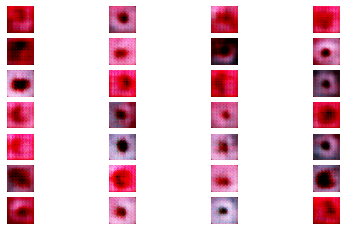

Training GAN at Time Step 1 of Epoch 14
1
************ for time_step 1, discriminator loss is 0.6676803231239319 ***********
******** for time_step 1, generator loss is 0.9891852140426636 ***********
Training GAN at Time Step 2 of Epoch 14
1
************ for time_step 2, discriminator loss is 0.7830674648284912 ***********
******** for time_step 2, generator loss is 3.765524387359619 ***********
Training GAN at Time Step 3 of Epoch 14
1
************ for time_step 3, discriminator loss is 0.5606738328933716 ***********
******** for time_step 3, generator loss is 1.1250967979431152 ***********
Training GAN at Time Step 4 of Epoch 14
1
************ for time_step 4, discriminator loss is 0.25186586380004883 ***********
******** for time_step 4, generator loss is 3.0597245693206787 ***********
Training GAN at Time Step 5 of Epoch 14
1
************ for time_step 5, discriminator loss is 0.29039257764816284 ***********
******** for time_step 5, generator loss is 2.481271743774414 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

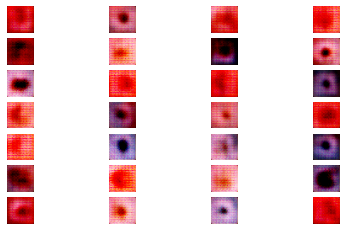

Training GAN at Time Step 1 of Epoch 15
1
************ for time_step 1, discriminator loss is 0.448407918214798 ***********
******** for time_step 1, generator loss is 2.534317970275879 ***********
Training GAN at Time Step 2 of Epoch 15
1
************ for time_step 2, discriminator loss is 0.6898998022079468 ***********
******** for time_step 2, generator loss is 1.014643907546997 ***********
Training GAN at Time Step 3 of Epoch 15
1
************ for time_step 3, discriminator loss is 0.8981969952583313 ***********
******** for time_step 3, generator loss is 3.004398822784424 ***********
Training GAN at Time Step 4 of Epoch 15
1
************ for time_step 4, discriminator loss is 1.4785346984863281 ***********
******** for time_step 4, generator loss is 0.4127900302410126 ***********
Training GAN at Time Step 5 of Epoch 15
1
************ for time_step 5, discriminator loss is 1.6366913318634033 ***********
******** for time_step 5, generator loss is 3.855748176574707 ***********
Train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 15
1
************ for time_step 28, discriminator loss is 0.6799932718276978 ***********
******** for time_step 28, generator loss is 1.567819356918335 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

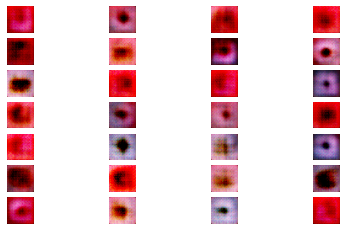

Training GAN at Time Step 1 of Epoch 16
1
************ for time_step 1, discriminator loss is 0.6936087608337402 ***********
******** for time_step 1, generator loss is 1.2740823030471802 ***********
Training GAN at Time Step 2 of Epoch 16
1
************ for time_step 2, discriminator loss is 0.724736213684082 ***********
******** for time_step 2, generator loss is 2.451734781265259 ***********
Training GAN at Time Step 3 of Epoch 16
1
************ for time_step 3, discriminator loss is 0.9587224721908569 ***********
******** for time_step 3, generator loss is 0.7581742405891418 ***********
Training GAN at Time Step 4 of Epoch 16
1
************ for time_step 4, discriminator loss is 0.8570667505264282 ***********
******** for time_step 4, generator loss is 3.021984577178955 ***********
Training GAN at Time Step 5 of Epoch 16
1
************ for time_step 5, discriminator loss is 0.7152686715126038 ***********
******** for time_step 5, generator loss is 0.9652527570724487 ***********
Tra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

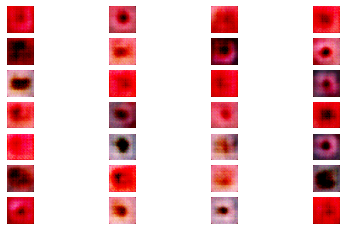

Training GAN at Time Step 1 of Epoch 17
1
************ for time_step 1, discriminator loss is 0.6835021376609802 ***********
******** for time_step 1, generator loss is 2.1162877082824707 ***********
Training GAN at Time Step 2 of Epoch 17
1
************ for time_step 2, discriminator loss is 0.7937731146812439 ***********
******** for time_step 2, generator loss is 0.9443702697753906 ***********
Training GAN at Time Step 3 of Epoch 17
1
************ for time_step 3, discriminator loss is 0.7756309509277344 ***********
******** for time_step 3, generator loss is 2.4670798778533936 ***********
Training GAN at Time Step 4 of Epoch 17
1
************ for time_step 4, discriminator loss is 0.806719183921814 ***********
******** for time_step 4, generator loss is 0.8137367963790894 ***********
Training GAN at Time Step 5 of Epoch 17
1
************ for time_step 5, discriminator loss is 0.766740083694458 ***********
******** for time_step 5, generator loss is 2.810659408569336 ***********
Tra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

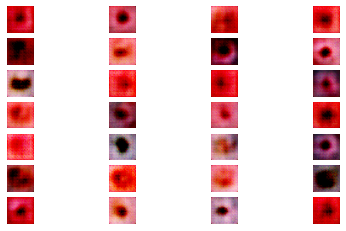

Training GAN at Time Step 1 of Epoch 18
1
************ for time_step 1, discriminator loss is 0.5656388998031616 ***********
******** for time_step 1, generator loss is 1.3423750400543213 ***********
Training GAN at Time Step 2 of Epoch 18
1
************ for time_step 2, discriminator loss is 0.6322486996650696 ***********
******** for time_step 2, generator loss is 1.7692409753799438 ***********
Training GAN at Time Step 3 of Epoch 18
1
************ for time_step 3, discriminator loss is 0.6214944124221802 ***********
******** for time_step 3, generator loss is 1.5029884576797485 ***********
Training GAN at Time Step 4 of Epoch 18
1
************ for time_step 4, discriminator loss is 0.5407081842422485 ***********
******** for time_step 4, generator loss is 1.9578529596328735 ***********
Training GAN at Time Step 5 of Epoch 18
1
************ for time_step 5, discriminator loss is 0.6075762510299683 ***********
******** for time_step 5, generator loss is 1.161351203918457 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


******** for time_step 28, generator loss is 1.7964047193527222 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

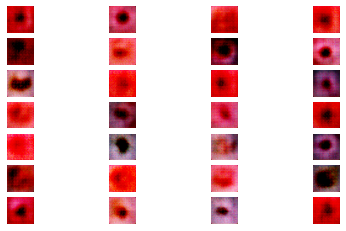

Training GAN at Time Step 1 of Epoch 19
1
************ for time_step 1, discriminator loss is 0.6318246126174927 ***********
******** for time_step 1, generator loss is 2.3127968311309814 ***********
Training GAN at Time Step 2 of Epoch 19
1
************ for time_step 2, discriminator loss is 0.7158881425857544 ***********
******** for time_step 2, generator loss is 1.1407934427261353 ***********
Training GAN at Time Step 3 of Epoch 19
1
************ for time_step 3, discriminator loss is 0.7003580331802368 ***********
******** for time_step 3, generator loss is 1.4961564540863037 ***********
Training GAN at Time Step 4 of Epoch 19
1
************ for time_step 4, discriminator loss is 0.5846782326698303 ***********
******** for time_step 4, generator loss is 1.9769660234451294 ***********
Training GAN at Time Step 5 of Epoch 19
1
************ for time_step 5, discriminator loss is 0.6181619763374329 ***********
******** for time_step 5, generator loss is 1.309001088142395 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

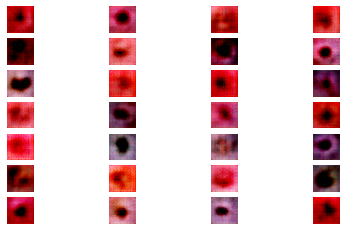

Training GAN at Time Step 1 of Epoch 20
1
************ for time_step 1, discriminator loss is 1.3377108573913574 ***********
******** for time_step 1, generator loss is 3.66558575630188 ***********
Training GAN at Time Step 2 of Epoch 20
1
************ for time_step 2, discriminator loss is 1.1016335487365723 ***********
******** for time_step 2, generator loss is 0.6533835530281067 ***********
Training GAN at Time Step 3 of Epoch 20
1
************ for time_step 3, discriminator loss is 0.7637964487075806 ***********
******** for time_step 3, generator loss is 2.215116024017334 ***********
Training GAN at Time Step 4 of Epoch 20
1
************ for time_step 4, discriminator loss is 0.6412290334701538 ***********
******** for time_step 4, generator loss is 1.5420889854431152 ***********
Training GAN at Time Step 5 of Epoch 20
1
************ for time_step 5, discriminator loss is 0.6880559921264648 ***********
******** for time_step 5, generator loss is 1.115523338317871 ***********
Trai

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

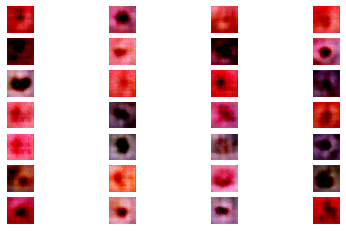

Training GAN at Time Step 1 of Epoch 21
1
************ for time_step 1, discriminator loss is 0.8140628337860107 ***********
******** for time_step 1, generator loss is 1.0391639471054077 ***********
Training GAN at Time Step 2 of Epoch 21
1
************ for time_step 2, discriminator loss is 0.8137590885162354 ***********
******** for time_step 2, generator loss is 2.155076026916504 ***********
Training GAN at Time Step 3 of Epoch 21
1
************ for time_step 3, discriminator loss is 0.7974908947944641 ***********
******** for time_step 3, generator loss is 0.9479674696922302 ***********
Training GAN at Time Step 4 of Epoch 21
1
************ for time_step 4, discriminator loss is 0.7388672828674316 ***********
******** for time_step 4, generator loss is 2.3048415184020996 ***********
Training GAN at Time Step 5 of Epoch 21
1
************ for time_step 5, discriminator loss is 0.6729626059532166 ***********
******** for time_step 5, generator loss is 1.3259872198104858 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

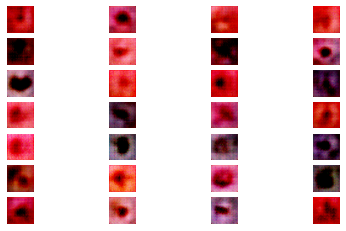

Training GAN at Time Step 1 of Epoch 22
1
************ for time_step 1, discriminator loss is 0.5719919800758362 ***********
******** for time_step 1, generator loss is 1.8247039318084717 ***********
Training GAN at Time Step 2 of Epoch 22
1
************ for time_step 2, discriminator loss is 0.7108326554298401 ***********
******** for time_step 2, generator loss is 1.3043560981750488 ***********
Training GAN at Time Step 3 of Epoch 22
1
************ for time_step 3, discriminator loss is 0.7290569543838501 ***********
******** for time_step 3, generator loss is 1.3606441020965576 ***********
Training GAN at Time Step 4 of Epoch 22
1
************ for time_step 4, discriminator loss is 0.7658625841140747 ***********
******** for time_step 4, generator loss is 1.5189099311828613 ***********
Training GAN at Time Step 5 of Epoch 22
1
************ for time_step 5, discriminator loss is 0.8351869583129883 ***********
******** for time_step 5, generator loss is 1.1069573163986206 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

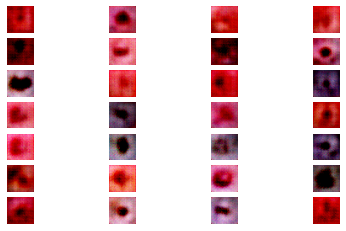

Training GAN at Time Step 1 of Epoch 23
1
************ for time_step 1, discriminator loss is 0.9388823509216309 ***********
******** for time_step 1, generator loss is 2.0289180278778076 ***********
Training GAN at Time Step 2 of Epoch 23
1
************ for time_step 2, discriminator loss is 0.967426598072052 ***********
******** for time_step 2, generator loss is 0.8275793790817261 ***********
Training GAN at Time Step 3 of Epoch 23
1
************ for time_step 3, discriminator loss is 0.9298858046531677 ***********
******** for time_step 3, generator loss is 2.2713370323181152 ***********
Training GAN at Time Step 4 of Epoch 23
1
************ for time_step 4, discriminator loss is 1.0861148834228516 ***********
******** for time_step 4, generator loss is 0.6459134221076965 ***********
Training GAN at Time Step 5 of Epoch 23
1
************ for time_step 5, discriminator loss is 0.9240560531616211 ***********
******** for time_step 5, generator loss is 2.259111166000366 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 23
1
************ for time_step 28, discriminator loss is 0.8248968720436096 ***********
******** for time_step 28, generator loss is 1.0266427993774414 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

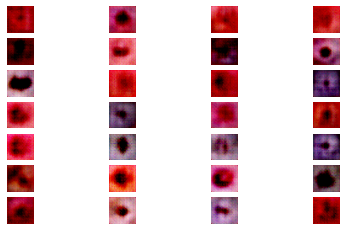

Training GAN at Time Step 1 of Epoch 24
1
************ for time_step 1, discriminator loss is 0.6688271760940552 ***********
******** for time_step 1, generator loss is 1.8051817417144775 ***********
Training GAN at Time Step 2 of Epoch 24
1
************ for time_step 2, discriminator loss is 0.7417668700218201 ***********
******** for time_step 2, generator loss is 1.4716978073120117 ***********
Training GAN at Time Step 3 of Epoch 24
1
************ for time_step 3, discriminator loss is 0.8015856742858887 ***********
******** for time_step 3, generator loss is 1.0331968069076538 ***********
Training GAN at Time Step 4 of Epoch 24
1
************ for time_step 4, discriminator loss is 0.8818382024765015 ***********
******** for time_step 4, generator loss is 1.845458745956421 ***********
Training GAN at Time Step 5 of Epoch 24
1
************ for time_step 5, discriminator loss is 1.019750714302063 ***********
******** for time_step 5, generator loss is 0.7309602499008179 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

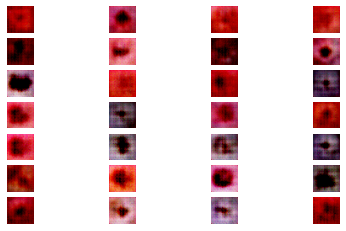

Training GAN at Time Step 1 of Epoch 25
1
************ for time_step 1, discriminator loss is 0.7025909423828125 ***********
******** for time_step 1, generator loss is 1.3688340187072754 ***********
Training GAN at Time Step 2 of Epoch 25
1
************ for time_step 2, discriminator loss is 0.6936360597610474 ***********
******** for time_step 2, generator loss is 1.4267932176589966 ***********
Training GAN at Time Step 3 of Epoch 25
1
************ for time_step 3, discriminator loss is 0.7048449516296387 ***********
******** for time_step 3, generator loss is 1.29059636592865 ***********
Training GAN at Time Step 4 of Epoch 25
1
************ for time_step 4, discriminator loss is 0.9008721113204956 ***********
******** for time_step 4, generator loss is 1.325931429862976 ***********
Training GAN at Time Step 5 of Epoch 25
1
************ for time_step 5, discriminator loss is 0.9231367707252502 ***********
******** for time_step 5, generator loss is 1.3356646299362183 ***********
Tra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


******** for time_step 28, generator loss is 1.2469865083694458 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

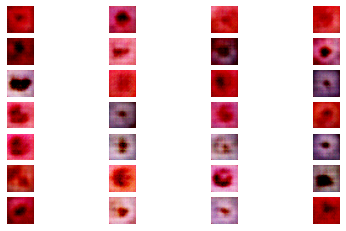

Training GAN at Time Step 1 of Epoch 26
1
************ for time_step 1, discriminator loss is 0.750309407711029 ***********
******** for time_step 1, generator loss is 1.5864754915237427 ***********
Training GAN at Time Step 2 of Epoch 26
1
************ for time_step 2, discriminator loss is 0.9267359375953674 ***********
******** for time_step 2, generator loss is 1.0114569664001465 ***********
Training GAN at Time Step 3 of Epoch 26
1
************ for time_step 3, discriminator loss is 1.1301851272583008 ***********
******** for time_step 3, generator loss is 1.5609548091888428 ***********
Training GAN at Time Step 4 of Epoch 26
1
************ for time_step 4, discriminator loss is 1.356658697128296 ***********
******** for time_step 4, generator loss is 0.5610179901123047 ***********
Training GAN at Time Step 5 of Epoch 26
1
************ for time_step 5, discriminator loss is 1.1217880249023438 ***********
******** for time_step 5, generator loss is 2.1055667400360107 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


******** for time_step 28, generator loss is 1.3529068231582642 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

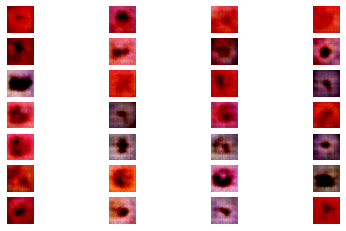

Training GAN at Time Step 1 of Epoch 27
1
************ for time_step 1, discriminator loss is 0.8993382453918457 ***********
******** for time_step 1, generator loss is 1.371317982673645 ***********
Training GAN at Time Step 2 of Epoch 27
1
************ for time_step 2, discriminator loss is 0.9611420631408691 ***********
******** for time_step 2, generator loss is 1.2395246028900146 ***********
Training GAN at Time Step 3 of Epoch 27
1
************ for time_step 3, discriminator loss is 1.1179370880126953 ***********
******** for time_step 3, generator loss is 0.7799736261367798 ***********
Training GAN at Time Step 4 of Epoch 27
1
************ for time_step 4, discriminator loss is 1.3448432683944702 ***********
******** for time_step 4, generator loss is 2.0012295246124268 ***********
Training GAN at Time Step 5 of Epoch 27
1
************ for time_step 5, discriminator loss is 1.6685274839401245 ***********
******** for time_step 5, generator loss is 0.3134170174598694 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

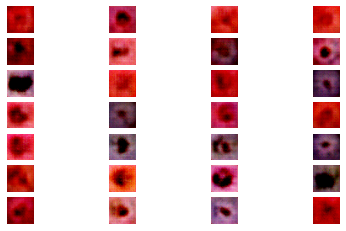

Training GAN at Time Step 1 of Epoch 28
1
************ for time_step 1, discriminator loss is 0.9749404191970825 ***********
******** for time_step 1, generator loss is 0.8267218470573425 ***********
Training GAN at Time Step 2 of Epoch 28
1
************ for time_step 2, discriminator loss is 0.9572905898094177 ***********
******** for time_step 2, generator loss is 1.271291732788086 ***********
Training GAN at Time Step 3 of Epoch 28
1
************ for time_step 3, discriminator loss is 0.9931372404098511 ***********
******** for time_step 3, generator loss is 1.2024670839309692 ***********
Training GAN at Time Step 4 of Epoch 28
1
************ for time_step 4, discriminator loss is 0.9841159582138062 ***********
******** for time_step 4, generator loss is 1.1236801147460938 ***********
Training GAN at Time Step 5 of Epoch 28
1
************ for time_step 5, discriminator loss is 0.8184051513671875 ***********
******** for time_step 5, generator loss is 1.519482970237732 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

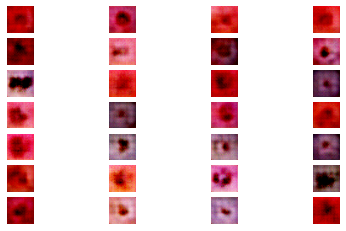

Training GAN at Time Step 1 of Epoch 29
1
************ for time_step 1, discriminator loss is 0.7602657079696655 ***********
******** for time_step 1, generator loss is 1.377037525177002 ***********
Training GAN at Time Step 2 of Epoch 29
1
************ for time_step 2, discriminator loss is 0.8837388753890991 ***********
******** for time_step 2, generator loss is 0.9555220603942871 ***********
Training GAN at Time Step 3 of Epoch 29
1
************ for time_step 3, discriminator loss is 0.9690779447555542 ***********
******** for time_step 3, generator loss is 1.9524943828582764 ***********
Training GAN at Time Step 4 of Epoch 29
1
************ for time_step 4, discriminator loss is 0.9427794814109802 ***********
******** for time_step 4, generator loss is 0.7748264670372009 ***********
Training GAN at Time Step 5 of Epoch 29
1
************ for time_step 5, discriminator loss is 0.9246828556060791 ***********
******** for time_step 5, generator loss is 1.630569577217102 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

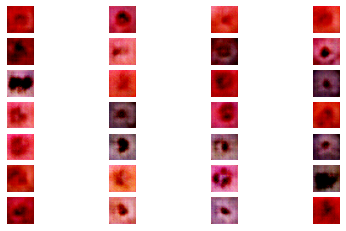

Training GAN at Time Step 1 of Epoch 30
1
************ for time_step 1, discriminator loss is 0.9180452823638916 ***********
******** for time_step 1, generator loss is 1.1900506019592285 ***********
Training GAN at Time Step 2 of Epoch 30
1
************ for time_step 2, discriminator loss is 0.9623081684112549 ***********
******** for time_step 2, generator loss is 1.134335994720459 ***********
Training GAN at Time Step 3 of Epoch 30
1
************ for time_step 3, discriminator loss is 0.9494020938873291 ***********
******** for time_step 3, generator loss is 1.2992156744003296 ***********
Training GAN at Time Step 4 of Epoch 30
1
************ for time_step 4, discriminator loss is 0.9243056774139404 ***********
******** for time_step 4, generator loss is 1.2175240516662598 ***********
Training GAN at Time Step 5 of Epoch 30
1
************ for time_step 5, discriminator loss is 1.0190153121948242 ***********
******** for time_step 5, generator loss is 1.3422191143035889 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 30
1
************ for time_step 28, discriminator loss is 0.9095653295516968 ***********
******** for time_step 28, generator loss is 1.1234692335128784 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

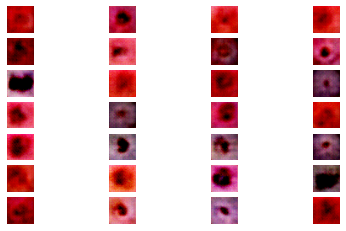

Training GAN at Time Step 1 of Epoch 31
1
************ for time_step 1, discriminator loss is 0.9205928444862366 ***********
******** for time_step 1, generator loss is 0.9473609924316406 ***********
Training GAN at Time Step 2 of Epoch 31
1
************ for time_step 2, discriminator loss is 0.9962507486343384 ***********
******** for time_step 2, generator loss is 1.7753746509552002 ***********
Training GAN at Time Step 3 of Epoch 31
1
************ for time_step 3, discriminator loss is 1.1286858320236206 ***********
******** for time_step 3, generator loss is 0.6413598656654358 ***********
Training GAN at Time Step 4 of Epoch 31
1
************ for time_step 4, discriminator loss is 1.3529536724090576 ***********
******** for time_step 4, generator loss is 2.2073814868927 ***********
Training GAN at Time Step 5 of Epoch 31
1
************ for time_step 5, discriminator loss is 1.3060225248336792 ***********
******** for time_step 5, generator loss is 0.47220367193222046 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

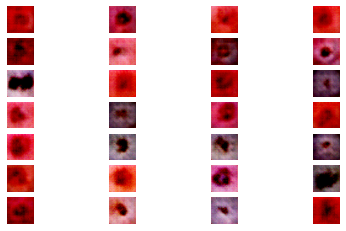

Training GAN at Time Step 1 of Epoch 32
1
************ for time_step 1, discriminator loss is 1.2245991230010986 ***********
******** for time_step 1, generator loss is 2.475145101547241 ***********
Training GAN at Time Step 2 of Epoch 32
1
************ for time_step 2, discriminator loss is 1.216475009918213 ***********
******** for time_step 2, generator loss is 0.5401806831359863 ***********
Training GAN at Time Step 3 of Epoch 32
1
************ for time_step 3, discriminator loss is 0.9257146716117859 ***********
******** for time_step 3, generator loss is 2.0219879150390625 ***********
Training GAN at Time Step 4 of Epoch 32
1
************ for time_step 4, discriminator loss is 1.033922791481018 ***********
******** for time_step 4, generator loss is 0.851028561592102 ***********
Training GAN at Time Step 5 of Epoch 32
1
************ for time_step 5, discriminator loss is 0.9445741176605225 ***********
******** for time_step 5, generator loss is 1.4079333543777466 ***********
Trai

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


******** for time_step 28, generator loss is 1.038597822189331 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

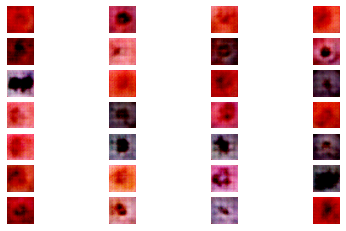

Training GAN at Time Step 1 of Epoch 33
1
************ for time_step 1, discriminator loss is 0.8386000394821167 ***********
******** for time_step 1, generator loss is 1.98146653175354 ***********
Training GAN at Time Step 2 of Epoch 33
1
************ for time_step 2, discriminator loss is 0.9150609970092773 ***********
******** for time_step 2, generator loss is 0.7877408266067505 ***********
Training GAN at Time Step 3 of Epoch 33
1
************ for time_step 3, discriminator loss is 0.7697337865829468 ***********
******** for time_step 3, generator loss is 1.9165034294128418 ***********
Training GAN at Time Step 4 of Epoch 33
1
************ for time_step 4, discriminator loss is 0.8486800789833069 ***********
******** for time_step 4, generator loss is 1.0019220113754272 ***********
Training GAN at Time Step 5 of Epoch 33
1
************ for time_step 5, discriminator loss is 0.730381429195404 ***********
******** for time_step 5, generator loss is 1.5677483081817627 ***********
Tra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


******** for time_step 28, generator loss is 0.5101801156997681 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

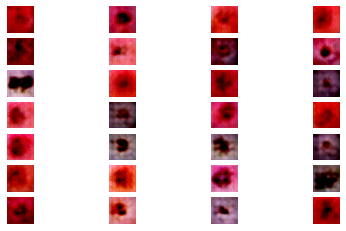

Training GAN at Time Step 1 of Epoch 34
1
************ for time_step 1, discriminator loss is 0.9336539506912231 ***********
******** for time_step 1, generator loss is 1.6373599767684937 ***********
Training GAN at Time Step 2 of Epoch 34
1
************ for time_step 2, discriminator loss is 0.8279057741165161 ***********
******** for time_step 2, generator loss is 1.2297899723052979 ***********
Training GAN at Time Step 3 of Epoch 34
1
************ for time_step 3, discriminator loss is 0.763434112071991 ***********
******** for time_step 3, generator loss is 1.3499683141708374 ***********
Training GAN at Time Step 4 of Epoch 34
1
************ for time_step 4, discriminator loss is 0.870917797088623 ***********
******** for time_step 4, generator loss is 1.053554654121399 ***********
Training GAN at Time Step 5 of Epoch 34
1
************ for time_step 5, discriminator loss is 0.8084114789962769 ***********
******** for time_step 5, generator loss is 1.602973461151123 ***********
Trai

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 34
1
************ for time_step 28, discriminator loss is 0.9018352031707764 ***********
******** for time_step 28, generator loss is 0.8131282329559326 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

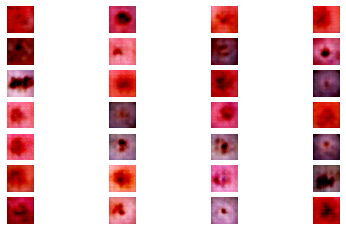

Training GAN at Time Step 1 of Epoch 35
1
************ for time_step 1, discriminator loss is 0.8306388258934021 ***********
******** for time_step 1, generator loss is 1.7669700384140015 ***********
Training GAN at Time Step 2 of Epoch 35
1
************ for time_step 2, discriminator loss is 0.9666045904159546 ***********
******** for time_step 2, generator loss is 1.1255056858062744 ***********
Training GAN at Time Step 3 of Epoch 35
1
************ for time_step 3, discriminator loss is 0.9631478786468506 ***********
******** for time_step 3, generator loss is 1.1002495288848877 ***********
Training GAN at Time Step 4 of Epoch 35
1
************ for time_step 4, discriminator loss is 0.863379716873169 ***********
******** for time_step 4, generator loss is 1.1918044090270996 ***********
Training GAN at Time Step 5 of Epoch 35
1
************ for time_step 5, discriminator loss is 0.8905589580535889 ***********
******** for time_step 5, generator loss is 1.4202277660369873 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

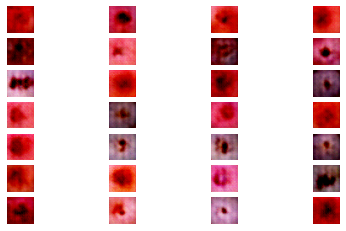

Training GAN at Time Step 1 of Epoch 36
1
************ for time_step 1, discriminator loss is 1.2263314723968506 ***********
******** for time_step 1, generator loss is 0.5867767930030823 ***********
Training GAN at Time Step 2 of Epoch 36
1
************ for time_step 2, discriminator loss is 0.9454679489135742 ***********
******** for time_step 2, generator loss is 2.020353317260742 ***********
Training GAN at Time Step 3 of Epoch 36
1
************ for time_step 3, discriminator loss is 0.9011572599411011 ***********
******** for time_step 3, generator loss is 1.0040779113769531 ***********
Training GAN at Time Step 4 of Epoch 36
1
************ for time_step 4, discriminator loss is 0.7311514019966125 ***********
******** for time_step 4, generator loss is 1.3349682092666626 ***********
Training GAN at Time Step 5 of Epoch 36
1
************ for time_step 5, discriminator loss is 1.0045503377914429 ***********
******** for time_step 5, generator loss is 1.4915680885314941 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 36
1
************ for time_step 28, discriminator loss is 1.196882963180542 ***********
******** for time_step 28, generator loss is 0.6781997084617615 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

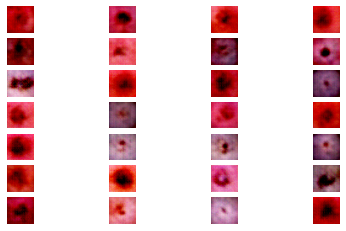

Training GAN at Time Step 1 of Epoch 37
1
************ for time_step 1, discriminator loss is 1.4072530269622803 ***********
******** for time_step 1, generator loss is 2.9090511798858643 ***********
Training GAN at Time Step 2 of Epoch 37
1
************ for time_step 2, discriminator loss is 1.5100516080856323 ***********
******** for time_step 2, generator loss is 0.4211033582687378 ***********
Training GAN at Time Step 3 of Epoch 37
1
************ for time_step 3, discriminator loss is 0.8170008659362793 ***********
******** for time_step 3, generator loss is 2.080143690109253 ***********
Training GAN at Time Step 4 of Epoch 37
1
************ for time_step 4, discriminator loss is 0.9448673129081726 ***********
******** for time_step 4, generator loss is 1.1807266473770142 ***********
Training GAN at Time Step 5 of Epoch 37
1
************ for time_step 5, discriminator loss is 0.9228566288948059 ***********
******** for time_step 5, generator loss is 1.0328994989395142 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

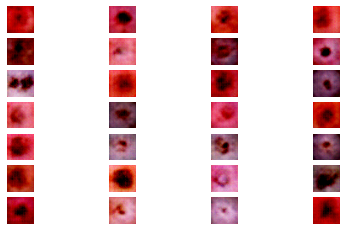

Training GAN at Time Step 1 of Epoch 38
1
************ for time_step 1, discriminator loss is 1.1884806156158447 ***********
******** for time_step 1, generator loss is 1.0587608814239502 ***********
Training GAN at Time Step 2 of Epoch 38
1
************ for time_step 2, discriminator loss is 0.9061484336853027 ***********
******** for time_step 2, generator loss is 1.297431468963623 ***********
Training GAN at Time Step 3 of Epoch 38
1
************ for time_step 3, discriminator loss is 0.9932304620742798 ***********
******** for time_step 3, generator loss is 1.0946924686431885 ***********
Training GAN at Time Step 4 of Epoch 38
1
************ for time_step 4, discriminator loss is 0.7988672256469727 ***********
******** for time_step 4, generator loss is 1.851650357246399 ***********
Training GAN at Time Step 5 of Epoch 38
1
************ for time_step 5, discriminator loss is 0.9476423859596252 ***********
******** for time_step 5, generator loss is 0.8711095452308655 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 38
1
************ for time_step 28, discriminator loss is 1.0170323848724365 ***********
******** for time_step 28, generator loss is 0.7626147270202637 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

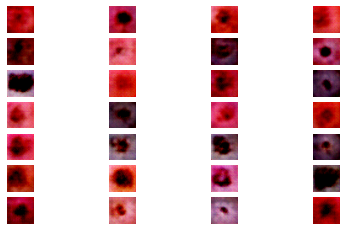

Training GAN at Time Step 1 of Epoch 39
1
************ for time_step 1, discriminator loss is 0.9092236757278442 ***********
******** for time_step 1, generator loss is 2.2361960411071777 ***********
Training GAN at Time Step 2 of Epoch 39
1
************ for time_step 2, discriminator loss is 1.0047060251235962 ***********
******** for time_step 2, generator loss is 0.6654292941093445 ***********
Training GAN at Time Step 3 of Epoch 39
1
************ for time_step 3, discriminator loss is 0.9016190767288208 ***********
******** for time_step 3, generator loss is 1.9234731197357178 ***********
Training GAN at Time Step 4 of Epoch 39
1
************ for time_step 4, discriminator loss is 0.9259995222091675 ***********
******** for time_step 4, generator loss is 0.9622698426246643 ***********
Training GAN at Time Step 5 of Epoch 39
1
************ for time_step 5, discriminator loss is 0.9088402986526489 ***********
******** for time_step 5, generator loss is 1.1956682205200195 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 39
1
************ for time_step 28, discriminator loss is 1.2239198684692383 ***********
******** for time_step 28, generator loss is 1.3395442962646484 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

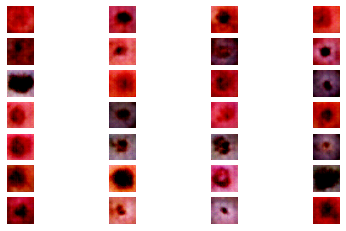

Training GAN at Time Step 1 of Epoch 40
1
************ for time_step 1, discriminator loss is 1.2198047637939453 ***********
******** for time_step 1, generator loss is 0.8375352621078491 ***********
Training GAN at Time Step 2 of Epoch 40
1
************ for time_step 2, discriminator loss is 0.8949860334396362 ***********
******** for time_step 2, generator loss is 1.3844292163848877 ***********
Training GAN at Time Step 3 of Epoch 40
1
************ for time_step 3, discriminator loss is 0.8062641620635986 ***********
******** for time_step 3, generator loss is 1.2095412015914917 ***********
Training GAN at Time Step 4 of Epoch 40
1
************ for time_step 4, discriminator loss is 0.7454401254653931 ***********
******** for time_step 4, generator loss is 1.5656346082687378 ***********
Training GAN at Time Step 5 of Epoch 40
1
************ for time_step 5, discriminator loss is 0.9886654019355774 ***********
******** for time_step 5, generator loss is 0.8911872506141663 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

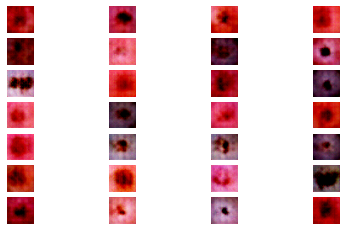

Training GAN at Time Step 1 of Epoch 41
1
************ for time_step 1, discriminator loss is 1.0891774892807007 ***********
******** for time_step 1, generator loss is 2.102789878845215 ***********
Training GAN at Time Step 2 of Epoch 41
1
************ for time_step 2, discriminator loss is 1.1233506202697754 ***********
******** for time_step 2, generator loss is 0.6917005777359009 ***********
Training GAN at Time Step 3 of Epoch 41
1
************ for time_step 3, discriminator loss is 0.9125248193740845 ***********
******** for time_step 3, generator loss is 1.4339213371276855 ***********
Training GAN at Time Step 4 of Epoch 41
1
************ for time_step 4, discriminator loss is 1.0875753164291382 ***********
******** for time_step 4, generator loss is 1.0837509632110596 ***********
Training GAN at Time Step 5 of Epoch 41
1
************ for time_step 5, discriminator loss is 0.9752048254013062 ***********
******** for time_step 5, generator loss is 1.0007888078689575 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

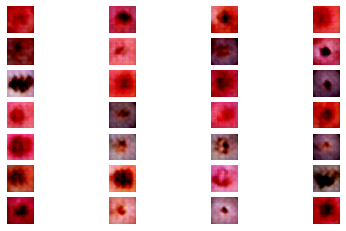

Training GAN at Time Step 1 of Epoch 42
1
************ for time_step 1, discriminator loss is 1.2401589155197144 ***********
******** for time_step 1, generator loss is 2.276627540588379 ***********
Training GAN at Time Step 2 of Epoch 42
1
************ for time_step 2, discriminator loss is 1.305363416671753 ***********
******** for time_step 2, generator loss is 0.5346545577049255 ***********
Training GAN at Time Step 3 of Epoch 42
1
************ for time_step 3, discriminator loss is 1.0375220775604248 ***********
******** for time_step 3, generator loss is 2.083066940307617 ***********
Training GAN at Time Step 4 of Epoch 42
1
************ for time_step 4, discriminator loss is 0.8344313502311707 ***********
******** for time_step 4, generator loss is 0.9806727170944214 ***********
Training GAN at Time Step 5 of Epoch 42
1
************ for time_step 5, discriminator loss is 0.7379467487335205 ***********
******** for time_step 5, generator loss is 1.639369010925293 ***********
Trai

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


************ for time_step 28, discriminator loss is 1.0171535015106201 ***********
******** for time_step 28, generator loss is 1.2091727256774902 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

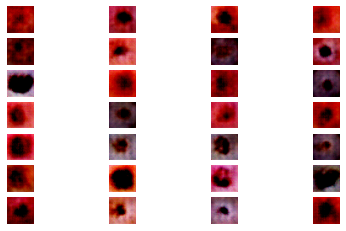

Training GAN at Time Step 1 of Epoch 43
1
************ for time_step 1, discriminator loss is 0.8228360414505005 ***********
******** for time_step 1, generator loss is 1.216078758239746 ***********
Training GAN at Time Step 2 of Epoch 43
1
************ for time_step 2, discriminator loss is 0.8420970439910889 ***********
******** for time_step 2, generator loss is 1.584673285484314 ***********
Training GAN at Time Step 3 of Epoch 43
1
************ for time_step 3, discriminator loss is 1.0625011920928955 ***********
******** for time_step 3, generator loss is 0.6709241271018982 ***********
Training GAN at Time Step 4 of Epoch 43
1
************ for time_step 4, discriminator loss is 1.1727240085601807 ***********
******** for time_step 4, generator loss is 2.4457614421844482 ***********
Training GAN at Time Step 5 of Epoch 43
1
************ for time_step 5, discriminator loss is 1.6872563362121582 ***********
******** for time_step 5, generator loss is 0.3306771218776703 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

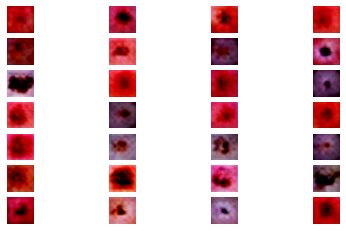

Training GAN at Time Step 1 of Epoch 44
1
************ for time_step 1, discriminator loss is 0.990671694278717 ***********
******** for time_step 1, generator loss is 0.864489734172821 ***********
Training GAN at Time Step 2 of Epoch 44
1
************ for time_step 2, discriminator loss is 1.025078296661377 ***********
******** for time_step 2, generator loss is 1.4376153945922852 ***********
Training GAN at Time Step 3 of Epoch 44
1
************ for time_step 3, discriminator loss is 1.2608616352081299 ***********
******** for time_step 3, generator loss is 0.8496527671813965 ***********
Training GAN at Time Step 4 of Epoch 44
1
************ for time_step 4, discriminator loss is 1.2496452331542969 ***********
******** for time_step 4, generator loss is 0.9471949934959412 ***********
Training GAN at Time Step 5 of Epoch 44
1
************ for time_step 5, discriminator loss is 1.1575983762741089 ***********
******** for time_step 5, generator loss is 1.0678863525390625 ***********
Tra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

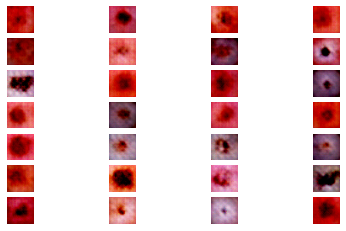

Training GAN at Time Step 1 of Epoch 45
1
************ for time_step 1, discriminator loss is 1.4947599172592163 ***********
******** for time_step 1, generator loss is 0.3919435739517212 ***********
Training GAN at Time Step 2 of Epoch 45
1
************ for time_step 2, discriminator loss is 0.8653236031532288 ***********
******** for time_step 2, generator loss is 2.2338669300079346 ***********
Training GAN at Time Step 3 of Epoch 45
1
************ for time_step 3, discriminator loss is 0.8042412400245667 ***********
******** for time_step 3, generator loss is 1.2722429037094116 ***********
Training GAN at Time Step 4 of Epoch 45
1
************ for time_step 4, discriminator loss is 1.0071057081222534 ***********
******** for time_step 4, generator loss is 0.8298951387405396 ***********
Training GAN at Time Step 5 of Epoch 45
1
************ for time_step 5, discriminator loss is 1.2448265552520752 ***********
******** for time_step 5, generator loss is 1.5837256908416748 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

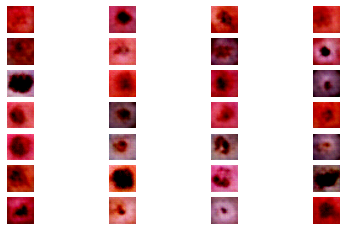

Training GAN at Time Step 1 of Epoch 46
1
************ for time_step 1, discriminator loss is 0.809218168258667 ***********
******** for time_step 1, generator loss is 1.8765681982040405 ***********
Training GAN at Time Step 2 of Epoch 46
1
************ for time_step 2, discriminator loss is 1.0973436832427979 ***********
******** for time_step 2, generator loss is 0.8394769430160522 ***********
Training GAN at Time Step 3 of Epoch 46
1
************ for time_step 3, discriminator loss is 1.301116943359375 ***********
******** for time_step 3, generator loss is 1.2046587467193604 ***********
Training GAN at Time Step 4 of Epoch 46
1
************ for time_step 4, discriminator loss is 1.2374238967895508 ***********
******** for time_step 4, generator loss is 0.6189714670181274 ***********
Training GAN at Time Step 5 of Epoch 46
1
************ for time_step 5, discriminator loss is 1.2426663637161255 ***********
******** for time_step 5, generator loss is 1.836158037185669 ***********
Tra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

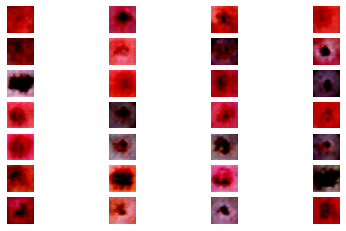

Training GAN at Time Step 1 of Epoch 47
1
************ for time_step 1, discriminator loss is 1.3152344226837158 ***********
******** for time_step 1, generator loss is 0.5369802117347717 ***********
Training GAN at Time Step 2 of Epoch 47
1
************ for time_step 2, discriminator loss is 0.9702497720718384 ***********
******** for time_step 2, generator loss is 1.8403507471084595 ***********
Training GAN at Time Step 3 of Epoch 47
1
************ for time_step 3, discriminator loss is 0.8200896978378296 ***********
******** for time_step 3, generator loss is 1.0761789083480835 ***********
Training GAN at Time Step 4 of Epoch 47
1
************ for time_step 4, discriminator loss is 0.8125416040420532 ***********
******** for time_step 4, generator loss is 1.2052943706512451 ***********
Training GAN at Time Step 5 of Epoch 47
1
************ for time_step 5, discriminator loss is 0.9120003581047058 ***********
******** for time_step 5, generator loss is 1.4493019580841064 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

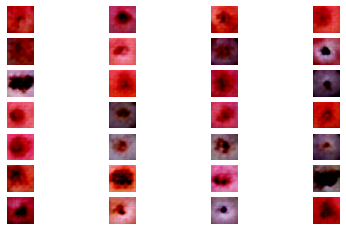

Training GAN at Time Step 1 of Epoch 48
1
************ for time_step 1, discriminator loss is 1.0563478469848633 ***********
******** for time_step 1, generator loss is 0.6579346656799316 ***********
Training GAN at Time Step 2 of Epoch 48
1
************ for time_step 2, discriminator loss is 1.1390942335128784 ***********
******** for time_step 2, generator loss is 2.07667875289917 ***********
Training GAN at Time Step 3 of Epoch 48
1
************ for time_step 3, discriminator loss is 1.3077400922775269 ***********
******** for time_step 3, generator loss is 0.5470141172409058 ***********
Training GAN at Time Step 4 of Epoch 48
1
************ for time_step 4, discriminator loss is 1.0248572826385498 ***********
******** for time_step 4, generator loss is 1.1511950492858887 ***********
Training GAN at Time Step 5 of Epoch 48
1
************ for time_step 5, discriminator loss is 1.0709657669067383 ***********
******** for time_step 5, generator loss is 1.5361725091934204 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


************ for time_step 28, discriminator loss is 1.4441008567810059 ***********
******** for time_step 28, generator loss is 2.1254546642303467 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

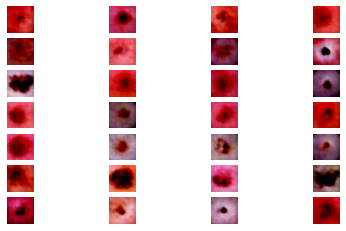

Training GAN at Time Step 1 of Epoch 49
1
************ for time_step 1, discriminator loss is 1.2592881917953491 ***********
******** for time_step 1, generator loss is 0.5759698748588562 ***********
Training GAN at Time Step 2 of Epoch 49
1
************ for time_step 2, discriminator loss is 0.8471174240112305 ***********
******** for time_step 2, generator loss is 1.6554546356201172 ***********
Training GAN at Time Step 3 of Epoch 49
1
************ for time_step 3, discriminator loss is 0.8282880187034607 ***********
******** for time_step 3, generator loss is 1.432472586631775 ***********
Training GAN at Time Step 4 of Epoch 49
1
************ for time_step 4, discriminator loss is 0.9910591840744019 ***********
******** for time_step 4, generator loss is 0.8804447054862976 ***********
Training GAN at Time Step 5 of Epoch 49
1
************ for time_step 5, discriminator loss is 1.2111258506774902 ***********
******** for time_step 5, generator loss is 1.4852821826934814 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


******** for time_step 28, generator loss is 1.5652060508728027 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

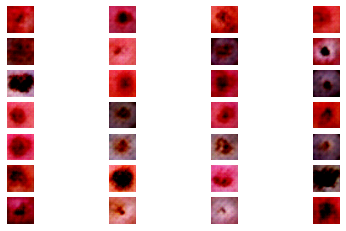

Training GAN at Time Step 1 of Epoch 50
1
************ for time_step 1, discriminator loss is 0.9154797196388245 ***********
******** for time_step 1, generator loss is 1.2300503253936768 ***********
Training GAN at Time Step 2 of Epoch 50
1
************ for time_step 2, discriminator loss is 1.0863115787506104 ***********
******** for time_step 2, generator loss is 0.9674813151359558 ***********
Training GAN at Time Step 3 of Epoch 50
1
************ for time_step 3, discriminator loss is 1.1100308895111084 ***********
******** for time_step 3, generator loss is 1.3494654893875122 ***********
Training GAN at Time Step 4 of Epoch 50
1
************ for time_step 4, discriminator loss is 1.1890641450881958 ***********
******** for time_step 4, generator loss is 0.6163758635520935 ***********
Training GAN at Time Step 5 of Epoch 50
1
************ for time_step 5, discriminator loss is 1.239184856414795 ***********
******** for time_step 5, generator loss is 2.1419849395751953 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 50
1
************ for time_step 28, discriminator loss is 1.2321422100067139 ***********
******** for time_step 28, generator loss is 1.193924069404602 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

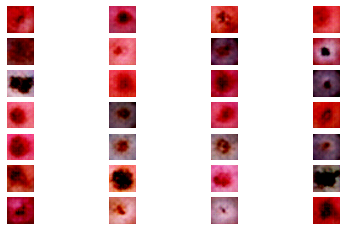

Training GAN at Time Step 1 of Epoch 51
1
************ for time_step 1, discriminator loss is 1.2850322723388672 ***********
******** for time_step 1, generator loss is 0.6799124479293823 ***********
Training GAN at Time Step 2 of Epoch 51
1
************ for time_step 2, discriminator loss is 1.2898931503295898 ***********
******** for time_step 2, generator loss is 2.0431108474731445 ***********
Training GAN at Time Step 3 of Epoch 51
1
************ for time_step 3, discriminator loss is 1.4144365787506104 ***********
******** for time_step 3, generator loss is 0.4099504351615906 ***********
Training GAN at Time Step 4 of Epoch 51
1
************ for time_step 4, discriminator loss is 1.217502474784851 ***********
******** for time_step 4, generator loss is 3.4039154052734375 ***********
Training GAN at Time Step 5 of Epoch 51
1
************ for time_step 5, discriminator loss is 1.3361821174621582 ***********
******** for time_step 5, generator loss is 0.4298401474952698 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 51
1
************ for time_step 28, discriminator loss is 0.8035846948623657 ***********
******** for time_step 28, generator loss is 1.3367831707000732 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

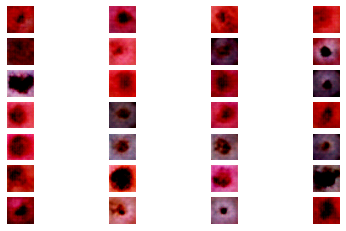

Training GAN at Time Step 1 of Epoch 52
1
************ for time_step 1, discriminator loss is 0.8431224822998047 ***********
******** for time_step 1, generator loss is 1.4305671453475952 ***********
Training GAN at Time Step 2 of Epoch 52
1
************ for time_step 2, discriminator loss is 0.9252617359161377 ***********
******** for time_step 2, generator loss is 1.0350182056427002 ***********
Training GAN at Time Step 3 of Epoch 52
1
************ for time_step 3, discriminator loss is 0.9049942493438721 ***********
******** for time_step 3, generator loss is 1.2870147228240967 ***********
Training GAN at Time Step 4 of Epoch 52
1
************ for time_step 4, discriminator loss is 0.937563955783844 ***********
******** for time_step 4, generator loss is 1.247840404510498 ***********
Training GAN at Time Step 5 of Epoch 52
1
************ for time_step 5, discriminator loss is 1.0566229820251465 ***********
******** for time_step 5, generator loss is 0.9439171552658081 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

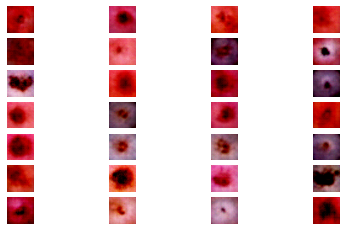

Training GAN at Time Step 1 of Epoch 53
1
************ for time_step 1, discriminator loss is 1.0080227851867676 ***********
******** for time_step 1, generator loss is 0.9796358346939087 ***********
Training GAN at Time Step 2 of Epoch 53
1
************ for time_step 2, discriminator loss is 0.9336740970611572 ***********
******** for time_step 2, generator loss is 1.6207269430160522 ***********
Training GAN at Time Step 3 of Epoch 53
1
************ for time_step 3, discriminator loss is 1.1385002136230469 ***********
******** for time_step 3, generator loss is 0.6943867206573486 ***********
Training GAN at Time Step 4 of Epoch 53
1
************ for time_step 4, discriminator loss is 1.2638964653015137 ***********
******** for time_step 4, generator loss is 1.870345950126648 ***********
Training GAN at Time Step 5 of Epoch 53
1
************ for time_step 5, discriminator loss is 1.5329045057296753 ***********
******** for time_step 5, generator loss is 0.38503018021583557 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

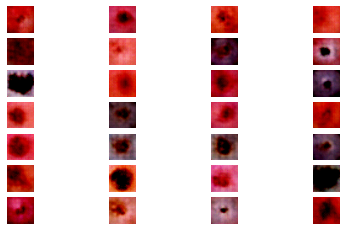

Training GAN at Time Step 1 of Epoch 54
1
************ for time_step 1, discriminator loss is 0.827801525592804 ***********
******** for time_step 1, generator loss is 1.3437484502792358 ***********
Training GAN at Time Step 2 of Epoch 54
1
************ for time_step 2, discriminator loss is 0.8996087312698364 ***********
******** for time_step 2, generator loss is 1.0631415843963623 ***********
Training GAN at Time Step 3 of Epoch 54
1
************ for time_step 3, discriminator loss is 1.009082555770874 ***********
******** for time_step 3, generator loss is 1.1503565311431885 ***********
Training GAN at Time Step 4 of Epoch 54
1
************ for time_step 4, discriminator loss is 1.1330177783966064 ***********
******** for time_step 4, generator loss is 0.9929252862930298 ***********
Training GAN at Time Step 5 of Epoch 54
1
************ for time_step 5, discriminator loss is 1.0540947914123535 ***********
******** for time_step 5, generator loss is 1.0457611083984375 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 54
1
************ for time_step 28, discriminator loss is 1.1353468894958496 ***********
******** for time_step 28, generator loss is 1.8099480867385864 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

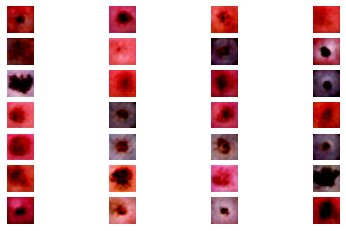

Training GAN at Time Step 1 of Epoch 55
1
************ for time_step 1, discriminator loss is 1.2290456295013428 ***********
******** for time_step 1, generator loss is 0.5816222429275513 ***********
Training GAN at Time Step 2 of Epoch 55
1
************ for time_step 2, discriminator loss is 1.1320315599441528 ***********
******** for time_step 2, generator loss is 1.968226671218872 ***********
Training GAN at Time Step 3 of Epoch 55
1
************ for time_step 3, discriminator loss is 1.0601500272750854 ***********
******** for time_step 3, generator loss is 0.6852848529815674 ***********
Training GAN at Time Step 4 of Epoch 55
1
************ for time_step 4, discriminator loss is 0.9662628173828125 ***********
******** for time_step 4, generator loss is 1.5067603588104248 ***********
Training GAN at Time Step 5 of Epoch 55
1
************ for time_step 5, discriminator loss is 0.8977252244949341 ***********
******** for time_step 5, generator loss is 1.109095573425293 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

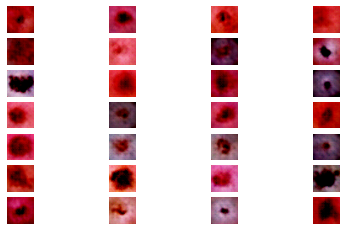

Training GAN at Time Step 1 of Epoch 56
1
************ for time_step 1, discriminator loss is 1.189582347869873 ***********
******** for time_step 1, generator loss is 0.5880501866340637 ***********
Training GAN at Time Step 2 of Epoch 56
1
************ for time_step 2, discriminator loss is 1.0864982604980469 ***********
******** for time_step 2, generator loss is 1.753952980041504 ***********
Training GAN at Time Step 3 of Epoch 56
1
************ for time_step 3, discriminator loss is 1.130252480506897 ***********
******** for time_step 3, generator loss is 0.7265477180480957 ***********
Training GAN at Time Step 4 of Epoch 56
1
************ for time_step 4, discriminator loss is 0.9337253570556641 ***********
******** for time_step 4, generator loss is 1.4393256902694702 ***********
Training GAN at Time Step 5 of Epoch 56
1
************ for time_step 5, discriminator loss is 0.999843418598175 ***********
******** for time_step 5, generator loss is 1.0029748678207397 ***********
Trai

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

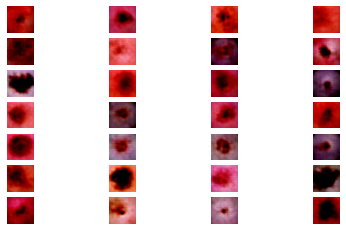

Training GAN at Time Step 1 of Epoch 57
1
************ for time_step 1, discriminator loss is 1.0205259323120117 ***********
******** for time_step 1, generator loss is 0.9089114665985107 ***********
Training GAN at Time Step 2 of Epoch 57
1
************ for time_step 2, discriminator loss is 1.1147956848144531 ***********
******** for time_step 2, generator loss is 1.681787133216858 ***********
Training GAN at Time Step 3 of Epoch 57
1
************ for time_step 3, discriminator loss is 1.405802607536316 ***********
******** for time_step 3, generator loss is 0.4081535041332245 ***********
Training GAN at Time Step 4 of Epoch 57
1
************ for time_step 4, discriminator loss is 1.5551518201828003 ***********
******** for time_step 4, generator loss is 3.069779634475708 ***********
Training GAN at Time Step 5 of Epoch 57
1
************ for time_step 5, discriminator loss is 1.5476796627044678 ***********
******** for time_step 5, generator loss is 0.3511399030685425 ***********
Tra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

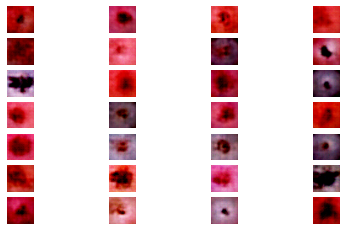

Training GAN at Time Step 1 of Epoch 58
1
************ for time_step 1, discriminator loss is 0.8586097359657288 ***********
******** for time_step 1, generator loss is 1.7551519870758057 ***********
Training GAN at Time Step 2 of Epoch 58
1
************ for time_step 2, discriminator loss is 0.8843870162963867 ***********
******** for time_step 2, generator loss is 1.0481089353561401 ***********
Training GAN at Time Step 3 of Epoch 58
1
************ for time_step 3, discriminator loss is 0.6906743049621582 ***********
******** for time_step 3, generator loss is 1.398791790008545 ***********
Training GAN at Time Step 4 of Epoch 58
1
************ for time_step 4, discriminator loss is 0.7739592790603638 ***********
******** for time_step 4, generator loss is 1.3800127506256104 ***********
Training GAN at Time Step 5 of Epoch 58
1
************ for time_step 5, discriminator loss is 0.8869144320487976 ***********
******** for time_step 5, generator loss is 0.9701634645462036 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 58
1
************ for time_step 28, discriminator loss is 1.33735990524292 ***********
******** for time_step 28, generator loss is 0.5249337553977966 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

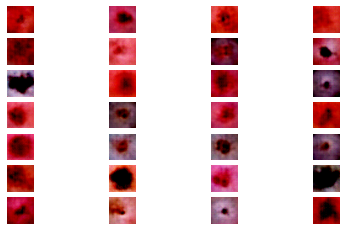

Training GAN at Time Step 1 of Epoch 59
1
************ for time_step 1, discriminator loss is 1.156053066253662 ***********
******** for time_step 1, generator loss is 2.156525135040283 ***********
Training GAN at Time Step 2 of Epoch 59
1
************ for time_step 2, discriminator loss is 1.0037771463394165 ***********
******** for time_step 2, generator loss is 0.7354558706283569 ***********
Training GAN at Time Step 3 of Epoch 59
1
************ for time_step 3, discriminator loss is 1.0028384923934937 ***********
******** for time_step 3, generator loss is 1.7176587581634521 ***********
Training GAN at Time Step 4 of Epoch 59
1
************ for time_step 4, discriminator loss is 1.0746948719024658 ***********
******** for time_step 4, generator loss is 0.7689725756645203 ***********
Training GAN at Time Step 5 of Epoch 59
1
************ for time_step 5, discriminator loss is 1.1985125541687012 ***********
******** for time_step 5, generator loss is 1.4433246850967407 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 59
1
************ for time_step 28, discriminator loss is 0.9579263925552368 ***********
******** for time_step 28, generator loss is 2.490598201751709 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

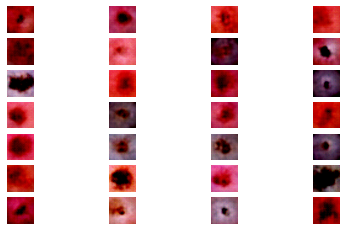

Training GAN at Time Step 1 of Epoch 60
1
************ for time_step 1, discriminator loss is 0.6690980195999146 ***********
******** for time_step 1, generator loss is 1.323848843574524 ***********
Training GAN at Time Step 2 of Epoch 60
1
************ for time_step 2, discriminator loss is 0.895117998123169 ***********
******** for time_step 2, generator loss is 0.8858551383018494 ***********
Training GAN at Time Step 3 of Epoch 60
1
************ for time_step 3, discriminator loss is 1.061456561088562 ***********
******** for time_step 3, generator loss is 1.9246265888214111 ***********
Training GAN at Time Step 4 of Epoch 60
1
************ for time_step 4, discriminator loss is 1.5204955339431763 ***********
******** for time_step 4, generator loss is 0.44542741775512695 ***********
Training GAN at Time Step 5 of Epoch 60
1
************ for time_step 5, discriminator loss is 1.1652660369873047 ***********
******** for time_step 5, generator loss is 1.4233033657073975 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

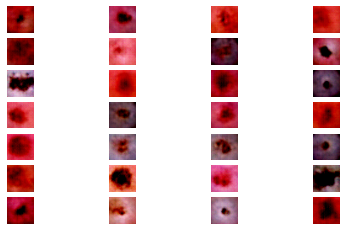

Training GAN at Time Step 1 of Epoch 61
1
************ for time_step 1, discriminator loss is 1.0314842462539673 ***********
******** for time_step 1, generator loss is 0.694270133972168 ***********
Training GAN at Time Step 2 of Epoch 61
1
************ for time_step 2, discriminator loss is 1.189521312713623 ***********
******** for time_step 2, generator loss is 1.8994481563568115 ***********
Training GAN at Time Step 3 of Epoch 61
1
************ for time_step 3, discriminator loss is 1.4215044975280762 ***********
******** for time_step 3, generator loss is 0.4429139494895935 ***********
Training GAN at Time Step 4 of Epoch 61
1
************ for time_step 4, discriminator loss is 1.1316442489624023 ***********
******** for time_step 4, generator loss is 1.4010686874389648 ***********
Training GAN at Time Step 5 of Epoch 61
1
************ for time_step 5, discriminator loss is 1.110405445098877 ***********
******** for time_step 5, generator loss is 1.0274702310562134 ***********
Tra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

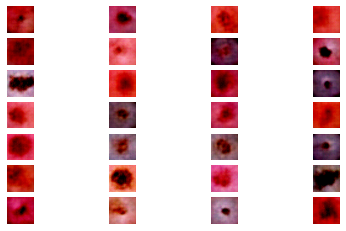

Training GAN at Time Step 1 of Epoch 62
1
************ for time_step 1, discriminator loss is 1.1876062154769897 ***********
******** for time_step 1, generator loss is 1.6679697036743164 ***********
Training GAN at Time Step 2 of Epoch 62
1
************ for time_step 2, discriminator loss is 1.4190787076950073 ***********
******** for time_step 2, generator loss is 0.43076181411743164 ***********
Training GAN at Time Step 3 of Epoch 62
1
************ for time_step 3, discriminator loss is 1.4311730861663818 ***********
******** for time_step 3, generator loss is 2.2509751319885254 ***********
Training GAN at Time Step 4 of Epoch 62
1
************ for time_step 4, discriminator loss is 1.1758801937103271 ***********
******** for time_step 4, generator loss is 0.569207489490509 ***********
Training GAN at Time Step 5 of Epoch 62
1
************ for time_step 5, discriminator loss is 0.9086147546768188 ***********
******** for time_step 5, generator loss is 1.952530860900879 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

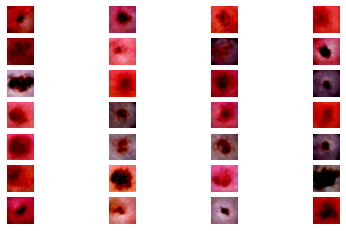

Training GAN at Time Step 1 of Epoch 63
1
************ for time_step 1, discriminator loss is 1.392765760421753 ***********
******** for time_step 1, generator loss is 0.4520743191242218 ***********
Training GAN at Time Step 2 of Epoch 63
1
************ for time_step 2, discriminator loss is 1.2586169242858887 ***********
******** for time_step 2, generator loss is 1.9036775827407837 ***********
Training GAN at Time Step 3 of Epoch 63
1
************ for time_step 3, discriminator loss is 1.0943467617034912 ***********
******** for time_step 3, generator loss is 0.6741876006126404 ***********
Training GAN at Time Step 4 of Epoch 63
1
************ for time_step 4, discriminator loss is 0.9512497186660767 ***********
******** for time_step 4, generator loss is 1.9830001592636108 ***********
Training GAN at Time Step 5 of Epoch 63
1
************ for time_step 5, discriminator loss is 0.88886559009552 ***********
******** for time_step 5, generator loss is 0.9847281575202942 ***********
Tra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

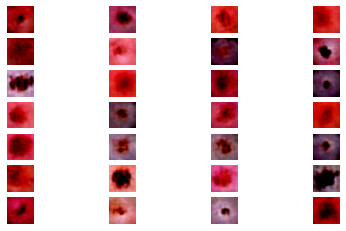

Training GAN at Time Step 1 of Epoch 64
1
************ for time_step 1, discriminator loss is 1.0343632698059082 ***********
******** for time_step 1, generator loss is 0.7439918518066406 ***********
Training GAN at Time Step 2 of Epoch 64
1
************ for time_step 2, discriminator loss is 1.1978391408920288 ***********
******** for time_step 2, generator loss is 1.7683626413345337 ***********
Training GAN at Time Step 3 of Epoch 64
1
************ for time_step 3, discriminator loss is 1.1763362884521484 ***********
******** for time_step 3, generator loss is 0.5297964215278625 ***********
Training GAN at Time Step 4 of Epoch 64
1
************ for time_step 4, discriminator loss is 1.0916805267333984 ***********
******** for time_step 4, generator loss is 1.7704719305038452 ***********
Training GAN at Time Step 5 of Epoch 64
1
************ for time_step 5, discriminator loss is 1.0573209524154663 ***********
******** for time_step 5, generator loss is 0.7363588213920593 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


******** for time_step 28, generator loss is 0.8734499216079712 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

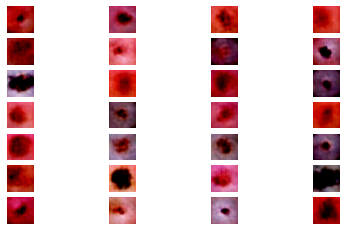

Training GAN at Time Step 1 of Epoch 65
1
************ for time_step 1, discriminator loss is 0.9834108948707581 ***********
******** for time_step 1, generator loss is 1.5708643198013306 ***********
Training GAN at Time Step 2 of Epoch 65
1
************ for time_step 2, discriminator loss is 1.2025253772735596 ***********
******** for time_step 2, generator loss is 0.6188408136367798 ***********
Training GAN at Time Step 3 of Epoch 65
1
************ for time_step 3, discriminator loss is 1.2922364473342896 ***********
******** for time_step 3, generator loss is 2.170630931854248 ***********
Training GAN at Time Step 4 of Epoch 65
1
************ for time_step 4, discriminator loss is 1.4529948234558105 ***********
******** for time_step 4, generator loss is 0.39855363965034485 ***********
Training GAN at Time Step 5 of Epoch 65
1
************ for time_step 5, discriminator loss is 1.1018704175949097 ***********
******** for time_step 5, generator loss is 2.4117841720581055 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

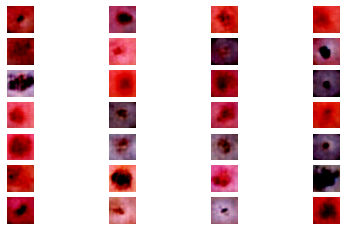

Training GAN at Time Step 1 of Epoch 66
1
************ for time_step 1, discriminator loss is 0.8302013874053955 ***********
******** for time_step 1, generator loss is 1.1862375736236572 ***********
Training GAN at Time Step 2 of Epoch 66
1
************ for time_step 2, discriminator loss is 0.9176058769226074 ***********
******** for time_step 2, generator loss is 1.192209243774414 ***********
Training GAN at Time Step 3 of Epoch 66
1
************ for time_step 3, discriminator loss is 1.1038610935211182 ***********
******** for time_step 3, generator loss is 0.8968567848205566 ***********
Training GAN at Time Step 4 of Epoch 66
1
************ for time_step 4, discriminator loss is 1.269662857055664 ***********
******** for time_step 4, generator loss is 1.232641577720642 ***********
Training GAN at Time Step 5 of Epoch 66
1
************ for time_step 5, discriminator loss is 1.29498291015625 ***********
******** for time_step 5, generator loss is 0.6525540351867676 ***********
Train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

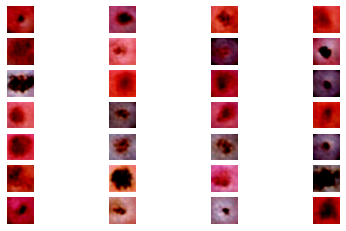

Training GAN at Time Step 1 of Epoch 67
1
************ for time_step 1, discriminator loss is 0.9768804907798767 ***********
******** for time_step 1, generator loss is 1.0648863315582275 ***********
Training GAN at Time Step 2 of Epoch 67
1
************ for time_step 2, discriminator loss is 1.0798156261444092 ***********
******** for time_step 2, generator loss is 1.18326735496521 ***********
Training GAN at Time Step 3 of Epoch 67
1
************ for time_step 3, discriminator loss is 1.0928735733032227 ***********
******** for time_step 3, generator loss is 0.817780613899231 ***********
Training GAN at Time Step 4 of Epoch 67
1
************ for time_step 4, discriminator loss is 1.1056737899780273 ***********
******** for time_step 4, generator loss is 1.7219927310943604 ***********
Training GAN at Time Step 5 of Epoch 67
1
************ for time_step 5, discriminator loss is 1.167632818222046 ***********
******** for time_step 5, generator loss is 0.5723238587379456 ***********
Trai

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

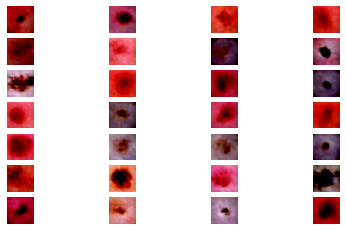

Training GAN at Time Step 1 of Epoch 68
1
************ for time_step 1, discriminator loss is 0.961102306842804 ***********
******** for time_step 1, generator loss is 1.2101327180862427 ***********
Training GAN at Time Step 2 of Epoch 68
1
************ for time_step 2, discriminator loss is 0.9116150140762329 ***********
******** for time_step 2, generator loss is 1.1274363994598389 ***********
Training GAN at Time Step 3 of Epoch 68
1
************ for time_step 3, discriminator loss is 0.960123598575592 ***********
******** for time_step 3, generator loss is 1.2376713752746582 ***********
Training GAN at Time Step 4 of Epoch 68
1
************ for time_step 4, discriminator loss is 1.1406418085098267 ***********
******** for time_step 4, generator loss is 0.7625644207000732 ***********
Training GAN at Time Step 5 of Epoch 68
1
************ for time_step 5, discriminator loss is 1.1169915199279785 ***********
******** for time_step 5, generator loss is 1.4034857749938965 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

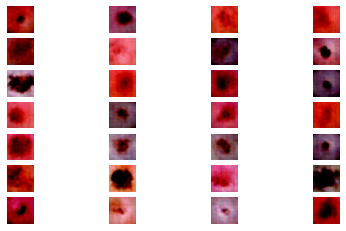

Training GAN at Time Step 1 of Epoch 69
1
************ for time_step 1, discriminator loss is 1.011925220489502 ***********
******** for time_step 1, generator loss is 1.179243564605713 ***********
Training GAN at Time Step 2 of Epoch 69
1
************ for time_step 2, discriminator loss is 1.01753568649292 ***********
******** for time_step 2, generator loss is 0.9851300716400146 ***********
Training GAN at Time Step 3 of Epoch 69
1
************ for time_step 3, discriminator loss is 1.0596692562103271 ***********
******** for time_step 3, generator loss is 1.3834213018417358 ***********
Training GAN at Time Step 4 of Epoch 69
1
************ for time_step 4, discriminator loss is 1.3339600563049316 ***********
******** for time_step 4, generator loss is 0.5050973892211914 ***********
Training GAN at Time Step 5 of Epoch 69
1
************ for time_step 5, discriminator loss is 1.4242075681686401 ***********
******** for time_step 5, generator loss is 2.546328544616699 ***********
Train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

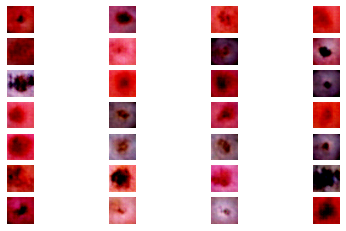

Training GAN at Time Step 1 of Epoch 70
1
************ for time_step 1, discriminator loss is 0.9310401082038879 ***********
******** for time_step 1, generator loss is 1.2190778255462646 ***********
Training GAN at Time Step 2 of Epoch 70
1
************ for time_step 2, discriminator loss is 0.971834123134613 ***********
******** for time_step 2, generator loss is 1.1491048336029053 ***********
Training GAN at Time Step 3 of Epoch 70
1
************ for time_step 3, discriminator loss is 0.9321602582931519 ***********
******** for time_step 3, generator loss is 0.9809433221817017 ***********
Training GAN at Time Step 4 of Epoch 70
1
************ for time_step 4, discriminator loss is 0.9575857520103455 ***********
******** for time_step 4, generator loss is 1.2104460000991821 ***********
Training GAN at Time Step 5 of Epoch 70
1
************ for time_step 5, discriminator loss is 0.9424951076507568 ***********
******** for time_step 5, generator loss is 1.0874760150909424 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 70
1
************ for time_step 28, discriminator loss is 1.4883567094802856 ***********
******** for time_step 28, generator loss is 0.40665996074676514 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

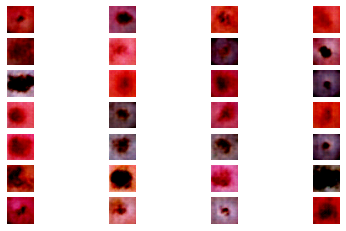

Training GAN at Time Step 1 of Epoch 71
1
************ for time_step 1, discriminator loss is 1.1311423778533936 ***********
******** for time_step 1, generator loss is 1.7885910272598267 ***********
Training GAN at Time Step 2 of Epoch 71
1
************ for time_step 2, discriminator loss is 1.0488426685333252 ***********
******** for time_step 2, generator loss is 0.7202399373054504 ***********
Training GAN at Time Step 3 of Epoch 71
1
************ for time_step 3, discriminator loss is 0.9700339436531067 ***********
******** for time_step 3, generator loss is 1.828393578529358 ***********
Training GAN at Time Step 4 of Epoch 71
1
************ for time_step 4, discriminator loss is 1.0016818046569824 ***********
******** for time_step 4, generator loss is 0.7643589377403259 ***********
Training GAN at Time Step 5 of Epoch 71
1
************ for time_step 5, discriminator loss is 0.8368654847145081 ***********
******** for time_step 5, generator loss is 1.6459853649139404 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 71
1
************ for time_step 28, discriminator loss is 0.8257505893707275 ***********
******** for time_step 28, generator loss is 1.1796337366104126 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

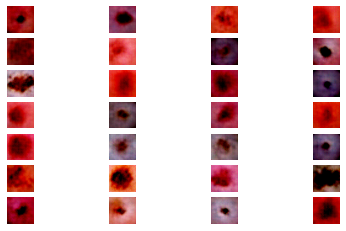

Training GAN at Time Step 1 of Epoch 72
1
************ for time_step 1, discriminator loss is 0.9585472345352173 ***********
******** for time_step 1, generator loss is 1.4951435327529907 ***********
Training GAN at Time Step 2 of Epoch 72
1
************ for time_step 2, discriminator loss is 1.1222785711288452 ***********
******** for time_step 2, generator loss is 0.6639553308486938 ***********
Training GAN at Time Step 3 of Epoch 72
1
************ for time_step 3, discriminator loss is 1.2286537885665894 ***********
******** for time_step 3, generator loss is 1.6956164836883545 ***********
Training GAN at Time Step 4 of Epoch 72
1
************ for time_step 4, discriminator loss is 1.3405756950378418 ***********
******** for time_step 4, generator loss is 0.4989197254180908 ***********
Training GAN at Time Step 5 of Epoch 72
1
************ for time_step 5, discriminator loss is 1.2495611906051636 ***********
******** for time_step 5, generator loss is 2.412415027618408 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 72
1
************ for time_step 28, discriminator loss is 0.8893846869468689 ***********
******** for time_step 28, generator loss is 1.2019343376159668 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

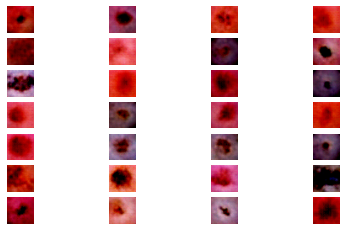

Training GAN at Time Step 1 of Epoch 73
1
************ for time_step 1, discriminator loss is 0.9455863237380981 ***********
******** for time_step 1, generator loss is 1.3076838254928589 ***********
Training GAN at Time Step 2 of Epoch 73
1
************ for time_step 2, discriminator loss is 1.0098886489868164 ***********
******** for time_step 2, generator loss is 0.9704195857048035 ***********
Training GAN at Time Step 3 of Epoch 73
1
************ for time_step 3, discriminator loss is 0.995913028717041 ***********
******** for time_step 3, generator loss is 1.2960346937179565 ***********
Training GAN at Time Step 4 of Epoch 73
1
************ for time_step 4, discriminator loss is 0.9063629508018494 ***********
******** for time_step 4, generator loss is 1.0150706768035889 ***********
Training GAN at Time Step 5 of Epoch 73
1
************ for time_step 5, discriminator loss is 0.956044614315033 ***********
******** for time_step 5, generator loss is 1.3220479488372803 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

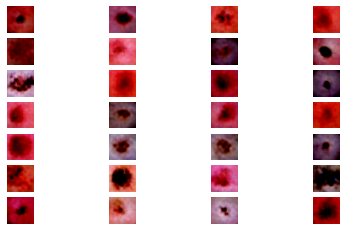

Training GAN at Time Step 1 of Epoch 74
1
************ for time_step 1, discriminator loss is 1.1216038465499878 ***********
******** for time_step 1, generator loss is 1.574866533279419 ***********
Training GAN at Time Step 2 of Epoch 74
1
************ for time_step 2, discriminator loss is 1.0425372123718262 ***********
******** for time_step 2, generator loss is 0.6643399596214294 ***********
Training GAN at Time Step 3 of Epoch 74
1
************ for time_step 3, discriminator loss is 1.0448570251464844 ***********
******** for time_step 3, generator loss is 1.8808307647705078 ***********
Training GAN at Time Step 4 of Epoch 74
1
************ for time_step 4, discriminator loss is 1.10640549659729 ***********
******** for time_step 4, generator loss is 0.6770690083503723 ***********
Training GAN at Time Step 5 of Epoch 74
1
************ for time_step 5, discriminator loss is 0.8910526037216187 ***********
******** for time_step 5, generator loss is 1.82316255569458 ***********
Train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 74
1
************ for time_step 28, discriminator loss is 0.9126484394073486 ***********
******** for time_step 28, generator loss is 1.3020379543304443 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

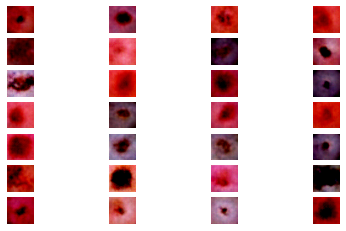

Training GAN at Time Step 1 of Epoch 75
1
************ for time_step 1, discriminator loss is 1.0474299192428589 ***********
******** for time_step 1, generator loss is 0.9450045228004456 ***********
Training GAN at Time Step 2 of Epoch 75
1
************ for time_step 2, discriminator loss is 1.0902493000030518 ***********
******** for time_step 2, generator loss is 1.4231319427490234 ***********
Training GAN at Time Step 3 of Epoch 75
1
************ for time_step 3, discriminator loss is 1.4462872743606567 ***********
******** for time_step 3, generator loss is 0.47454267740249634 ***********
Training GAN at Time Step 4 of Epoch 75
1
************ for time_step 4, discriminator loss is 1.4968432188034058 ***********
******** for time_step 4, generator loss is 1.9586360454559326 ***********
Training GAN at Time Step 5 of Epoch 75
1
************ for time_step 5, discriminator loss is 1.5028159618377686 ***********
******** for time_step 5, generator loss is 0.37660717964172363 **********

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


******** for time_step 28, generator loss is 2.173797845840454 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

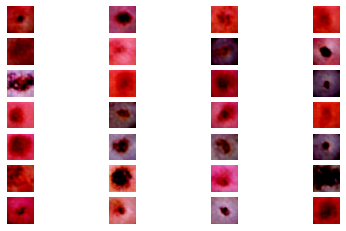

Training GAN at Time Step 1 of Epoch 76
1
************ for time_step 1, discriminator loss is 0.712714433670044 ***********
******** for time_step 1, generator loss is 1.6058332920074463 ***********
Training GAN at Time Step 2 of Epoch 76
1
************ for time_step 2, discriminator loss is 0.8821121454238892 ***********
******** for time_step 2, generator loss is 0.9215290546417236 ***********
Training GAN at Time Step 3 of Epoch 76
1
************ for time_step 3, discriminator loss is 0.8348686695098877 ***********
******** for time_step 3, generator loss is 1.3083248138427734 ***********
Training GAN at Time Step 4 of Epoch 76
1
************ for time_step 4, discriminator loss is 1.033951997756958 ***********
******** for time_step 4, generator loss is 1.0402259826660156 ***********
Training GAN at Time Step 5 of Epoch 76
1
************ for time_step 5, discriminator loss is 1.0961151123046875 ***********
******** for time_step 5, generator loss is 0.9041931629180908 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

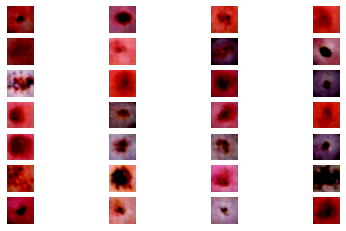

Training GAN at Time Step 1 of Epoch 77
1
************ for time_step 1, discriminator loss is 0.9093140363693237 ***********
******** for time_step 1, generator loss is 1.0888606309890747 ***********
Training GAN at Time Step 2 of Epoch 77
1
************ for time_step 2, discriminator loss is 0.8445874452590942 ***********
******** for time_step 2, generator loss is 1.3548282384872437 ***********
Training GAN at Time Step 3 of Epoch 77
1
************ for time_step 3, discriminator loss is 0.9290631413459778 ***********
******** for time_step 3, generator loss is 1.1328237056732178 ***********
Training GAN at Time Step 4 of Epoch 77
1
************ for time_step 4, discriminator loss is 0.9163534641265869 ***********
******** for time_step 4, generator loss is 1.0901410579681396 ***********
Training GAN at Time Step 5 of Epoch 77
1
************ for time_step 5, discriminator loss is 0.9924509525299072 ***********
******** for time_step 5, generator loss is 1.0437705516815186 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


******** for time_step 28, generator loss is 1.0687425136566162 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

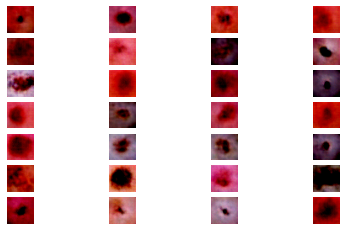

Training GAN at Time Step 1 of Epoch 78
1
************ for time_step 1, discriminator loss is 0.8983485102653503 ***********
******** for time_step 1, generator loss is 1.169471025466919 ***********
Training GAN at Time Step 2 of Epoch 78
1
************ for time_step 2, discriminator loss is 0.967128336429596 ***********
******** for time_step 2, generator loss is 1.1625421047210693 ***********
Training GAN at Time Step 3 of Epoch 78
1
************ for time_step 3, discriminator loss is 1.017118215560913 ***********
******** for time_step 3, generator loss is 0.9956017732620239 ***********
Training GAN at Time Step 4 of Epoch 78
1
************ for time_step 4, discriminator loss is 1.0828897953033447 ***********
******** for time_step 4, generator loss is 1.2387932538986206 ***********
Training GAN at Time Step 5 of Epoch 78
1
************ for time_step 5, discriminator loss is 0.985061526298523 ***********
******** for time_step 5, generator loss is 0.8302370309829712 ***********
Trai

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

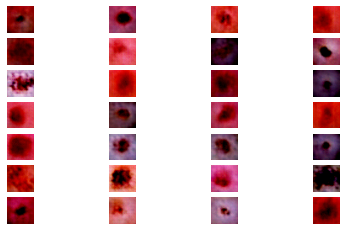

Training GAN at Time Step 1 of Epoch 79
1
************ for time_step 1, discriminator loss is 0.9719099998474121 ***********
******** for time_step 1, generator loss is 1.8496311902999878 ***********
Training GAN at Time Step 2 of Epoch 79
1
************ for time_step 2, discriminator loss is 1.182877779006958 ***********
******** for time_step 2, generator loss is 0.5680684447288513 ***********
Training GAN at Time Step 3 of Epoch 79
1
************ for time_step 3, discriminator loss is 0.9486846923828125 ***********
******** for time_step 3, generator loss is 1.8667607307434082 ***********
Training GAN at Time Step 4 of Epoch 79
1
************ for time_step 4, discriminator loss is 0.8477135896682739 ***********
******** for time_step 4, generator loss is 0.9992403984069824 ***********
Training GAN at Time Step 5 of Epoch 79
1
************ for time_step 5, discriminator loss is 0.9159934520721436 ***********
******** for time_step 5, generator loss is 1.207735538482666 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

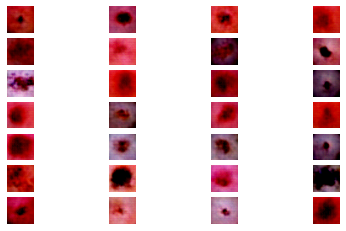

Training GAN at Time Step 1 of Epoch 80
1
************ for time_step 1, discriminator loss is 1.2839343547821045 ***********
******** for time_step 1, generator loss is 0.6140792369842529 ***********
Training GAN at Time Step 2 of Epoch 80
1
************ for time_step 2, discriminator loss is 1.0745445489883423 ***********
******** for time_step 2, generator loss is 1.9336819648742676 ***********
Training GAN at Time Step 3 of Epoch 80
1
************ for time_step 3, discriminator loss is 1.051292896270752 ***********
******** for time_step 3, generator loss is 0.674744725227356 ***********
Training GAN at Time Step 4 of Epoch 80
1
************ for time_step 4, discriminator loss is 1.0569140911102295 ***********
******** for time_step 4, generator loss is 1.9015556573867798 ***********
Training GAN at Time Step 5 of Epoch 80
1
************ for time_step 5, discriminator loss is 1.0216090679168701 ***********
******** for time_step 5, generator loss is 0.7429274916648865 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


******** for time_step 28, generator loss is 2.048802137374878 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

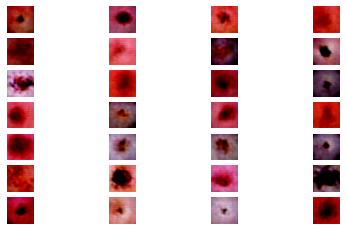

Training GAN at Time Step 1 of Epoch 81
1
************ for time_step 1, discriminator loss is 1.2257755994796753 ***********
******** for time_step 1, generator loss is 0.5761788487434387 ***********
Training GAN at Time Step 2 of Epoch 81
1
************ for time_step 2, discriminator loss is 0.8261562585830688 ***********
******** for time_step 2, generator loss is 2.1372909545898438 ***********
Training GAN at Time Step 3 of Epoch 81
1
************ for time_step 3, discriminator loss is 1.0409884452819824 ***********
******** for time_step 3, generator loss is 0.8365793824195862 ***********
Training GAN at Time Step 4 of Epoch 81
1
************ for time_step 4, discriminator loss is 1.1198080778121948 ***********
******** for time_step 4, generator loss is 1.2941844463348389 ***********
Training GAN at Time Step 5 of Epoch 81
1
************ for time_step 5, discriminator loss is 1.0827871561050415 ***********
******** for time_step 5, generator loss is 0.7532115578651428 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 81
1
************ for time_step 28, discriminator loss is 0.7993241548538208 ***********
******** for time_step 28, generator loss is 1.1606999635696411 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

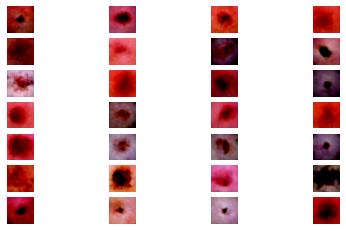

Training GAN at Time Step 1 of Epoch 82
1
************ for time_step 1, discriminator loss is 0.8751355409622192 ***********
******** for time_step 1, generator loss is 1.3559298515319824 ***********
Training GAN at Time Step 2 of Epoch 82
1
************ for time_step 2, discriminator loss is 0.9560979604721069 ***********
******** for time_step 2, generator loss is 1.0915467739105225 ***********
Training GAN at Time Step 3 of Epoch 82
1
************ for time_step 3, discriminator loss is 1.1393561363220215 ***********
******** for time_step 3, generator loss is 1.0043315887451172 ***********
Training GAN at Time Step 4 of Epoch 82
1
************ for time_step 4, discriminator loss is 1.201962947845459 ***********
******** for time_step 4, generator loss is 0.9223897457122803 ***********
Training GAN at Time Step 5 of Epoch 82
1
************ for time_step 5, discriminator loss is 0.9113236665725708 ***********
******** for time_step 5, generator loss is 1.179848074913025 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

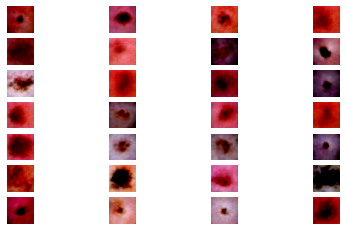

Training GAN at Time Step 1 of Epoch 83
1
************ for time_step 1, discriminator loss is 0.9720463752746582 ***********
******** for time_step 1, generator loss is 1.2021046876907349 ***********
Training GAN at Time Step 2 of Epoch 83
1
************ for time_step 2, discriminator loss is 1.0905749797821045 ***********
******** for time_step 2, generator loss is 1.1761834621429443 ***********
Training GAN at Time Step 3 of Epoch 83
1
************ for time_step 3, discriminator loss is 1.3101794719696045 ***********
******** for time_step 3, generator loss is 0.5787913203239441 ***********
Training GAN at Time Step 4 of Epoch 83
1
************ for time_step 4, discriminator loss is 1.0998458862304688 ***********
******** for time_step 4, generator loss is 1.8888769149780273 ***********
Training GAN at Time Step 5 of Epoch 83
1
************ for time_step 5, discriminator loss is 0.9059372544288635 ***********
******** for time_step 5, generator loss is 0.8225666880607605 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

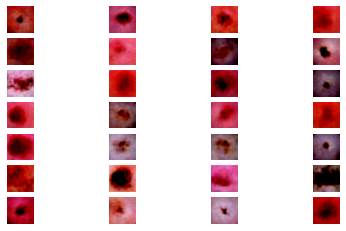

Training GAN at Time Step 1 of Epoch 84
1
************ for time_step 1, discriminator loss is 0.9305500984191895 ***********
******** for time_step 1, generator loss is 1.3781099319458008 ***********
Training GAN at Time Step 2 of Epoch 84
1
************ for time_step 2, discriminator loss is 0.9687163829803467 ***********
******** for time_step 2, generator loss is 1.03401517868042 ***********
Training GAN at Time Step 3 of Epoch 84
1
************ for time_step 3, discriminator loss is 1.1117841005325317 ***********
******** for time_step 3, generator loss is 1.0124337673187256 ***********
Training GAN at Time Step 4 of Epoch 84
1
************ for time_step 4, discriminator loss is 1.0812036991119385 ***********
******** for time_step 4, generator loss is 0.9669376611709595 ***********
Training GAN at Time Step 5 of Epoch 84
1
************ for time_step 5, discriminator loss is 1.0527844429016113 ***********
******** for time_step 5, generator loss is 1.3761804103851318 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


******** for time_step 28, generator loss is 0.9362872838973999 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

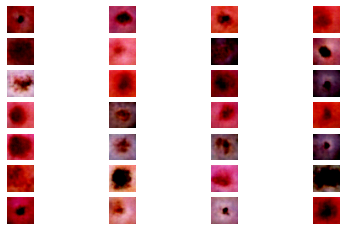

Training GAN at Time Step 1 of Epoch 85
1
************ for time_step 1, discriminator loss is 1.0576037168502808 ***********
******** for time_step 1, generator loss is 1.4968371391296387 ***********
Training GAN at Time Step 2 of Epoch 85
1
************ for time_step 2, discriminator loss is 1.0230907201766968 ***********
******** for time_step 2, generator loss is 0.7653870582580566 ***********
Training GAN at Time Step 3 of Epoch 85
1
************ for time_step 3, discriminator loss is 0.9687147736549377 ***********
******** for time_step 3, generator loss is 1.4341728687286377 ***********
Training GAN at Time Step 4 of Epoch 85
1
************ for time_step 4, discriminator loss is 0.9498409032821655 ***********
******** for time_step 4, generator loss is 1.1752643585205078 ***********
Training GAN at Time Step 5 of Epoch 85
1
************ for time_step 5, discriminator loss is 1.1009583473205566 ***********
******** for time_step 5, generator loss is 0.9046825170516968 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

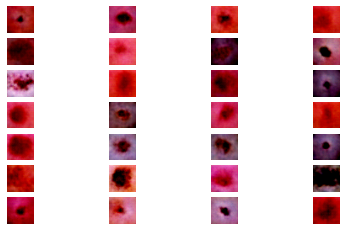

Training GAN at Time Step 1 of Epoch 86
1
************ for time_step 1, discriminator loss is 0.8297857046127319 ***********
******** for time_step 1, generator loss is 1.0626829862594604 ***********
Training GAN at Time Step 2 of Epoch 86
1
************ for time_step 2, discriminator loss is 0.9727309942245483 ***********
******** for time_step 2, generator loss is 1.4021673202514648 ***********
Training GAN at Time Step 3 of Epoch 86
1
************ for time_step 3, discriminator loss is 1.0546951293945312 ***********
******** for time_step 3, generator loss is 0.8202855587005615 ***********
Training GAN at Time Step 4 of Epoch 86
1
************ for time_step 4, discriminator loss is 0.9910207390785217 ***********
******** for time_step 4, generator loss is 1.6984317302703857 ***********
Training GAN at Time Step 5 of Epoch 86
1
************ for time_step 5, discriminator loss is 1.1213538646697998 ***********
******** for time_step 5, generator loss is 0.6038571000099182 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

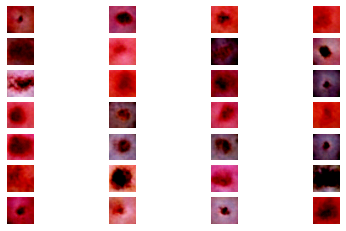

Training GAN at Time Step 1 of Epoch 87
1
************ for time_step 1, discriminator loss is 1.0698047876358032 ***********
******** for time_step 1, generator loss is 1.1981604099273682 ***********
Training GAN at Time Step 2 of Epoch 87
1
************ for time_step 2, discriminator loss is 0.9988484382629395 ***********
******** for time_step 2, generator loss is 0.9530282616615295 ***********
Training GAN at Time Step 3 of Epoch 87
1
************ for time_step 3, discriminator loss is 0.9498767852783203 ***********
******** for time_step 3, generator loss is 1.4366909265518188 ***********
Training GAN at Time Step 4 of Epoch 87
1
************ for time_step 4, discriminator loss is 0.9908143281936646 ***********
******** for time_step 4, generator loss is 0.8596171140670776 ***********
Training GAN at Time Step 5 of Epoch 87
1
************ for time_step 5, discriminator loss is 0.8920667171478271 ***********
******** for time_step 5, generator loss is 1.5759575366973877 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

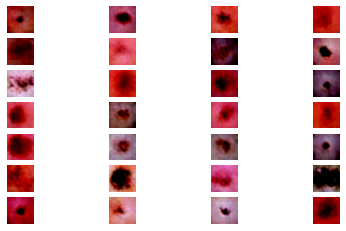

Training GAN at Time Step 1 of Epoch 88
1
************ for time_step 1, discriminator loss is 1.223252773284912 ***********
******** for time_step 1, generator loss is 1.6191284656524658 ***********
Training GAN at Time Step 2 of Epoch 88
1
************ for time_step 2, discriminator loss is 1.1962209939956665 ***********
******** for time_step 2, generator loss is 0.5970221161842346 ***********
Training GAN at Time Step 3 of Epoch 88
1
************ for time_step 3, discriminator loss is 0.8771166205406189 ***********
******** for time_step 3, generator loss is 2.3936688899993896 ***********
Training GAN at Time Step 4 of Epoch 88
1
************ for time_step 4, discriminator loss is 0.7909471988677979 ***********
******** for time_step 4, generator loss is 1.1082193851470947 ***********
Training GAN at Time Step 5 of Epoch 88
1
************ for time_step 5, discriminator loss is 0.8283571004867554 ***********
******** for time_step 5, generator loss is 1.1490204334259033 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

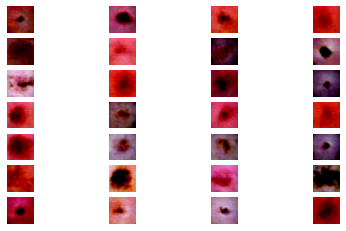

Training GAN at Time Step 1 of Epoch 89
1
************ for time_step 1, discriminator loss is 1.1132581233978271 ***********
******** for time_step 1, generator loss is 0.6002740859985352 ***********
Training GAN at Time Step 2 of Epoch 89
1
************ for time_step 2, discriminator loss is 1.1982901096343994 ***********
******** for time_step 2, generator loss is 2.232848882675171 ***********
Training GAN at Time Step 3 of Epoch 89
1
************ for time_step 3, discriminator loss is 1.1445682048797607 ***********
******** for time_step 3, generator loss is 0.5633175373077393 ***********
Training GAN at Time Step 4 of Epoch 89
1
************ for time_step 4, discriminator loss is 0.8555129766464233 ***********
******** for time_step 4, generator loss is 1.835125207901001 ***********
Training GAN at Time Step 5 of Epoch 89
1
************ for time_step 5, discriminator loss is 0.91725754737854 ***********
******** for time_step 5, generator loss is 1.0337872505187988 ***********
Trai

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 89
1
************ for time_step 28, discriminator loss is 0.8703600764274597 ***********
******** for time_step 28, generator loss is 1.1792207956314087 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

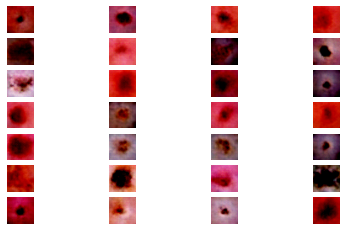

Training GAN at Time Step 1 of Epoch 90
1
************ for time_step 1, discriminator loss is 1.1141090393066406 ***********
******** for time_step 1, generator loss is 0.9945113658905029 ***********
Training GAN at Time Step 2 of Epoch 90
1
************ for time_step 2, discriminator loss is 1.2029433250427246 ***********
******** for time_step 2, generator loss is 0.9036436676979065 ***********
Training GAN at Time Step 3 of Epoch 90
1
************ for time_step 3, discriminator loss is 1.0161237716674805 ***********
******** for time_step 3, generator loss is 1.1910717487335205 ***********
Training GAN at Time Step 4 of Epoch 90
1
************ for time_step 4, discriminator loss is 0.9686309099197388 ***********
******** for time_step 4, generator loss is 1.0160913467407227 ***********
Training GAN at Time Step 5 of Epoch 90
1
************ for time_step 5, discriminator loss is 0.8999773263931274 ***********
******** for time_step 5, generator loss is 1.4922479391098022 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

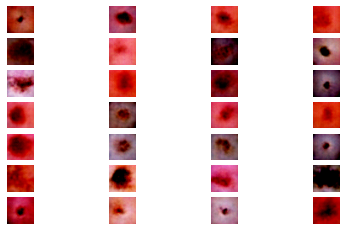

Training GAN at Time Step 1 of Epoch 91
1
************ for time_step 1, discriminator loss is 0.9246718883514404 ***********
******** for time_step 1, generator loss is 1.7944846153259277 ***********
Training GAN at Time Step 2 of Epoch 91
1
************ for time_step 2, discriminator loss is 1.0076518058776855 ***********
******** for time_step 2, generator loss is 0.9727843999862671 ***********
Training GAN at Time Step 3 of Epoch 91
1
************ for time_step 3, discriminator loss is 0.9314191341400146 ***********
******** for time_step 3, generator loss is 1.2247904539108276 ***********
Training GAN at Time Step 4 of Epoch 91
1
************ for time_step 4, discriminator loss is 0.8858858346939087 ***********
******** for time_step 4, generator loss is 1.33726966381073 ***********
Training GAN at Time Step 5 of Epoch 91
1
************ for time_step 5, discriminator loss is 1.059032917022705 ***********
******** for time_step 5, generator loss is 0.9483344554901123 ***********
Tra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

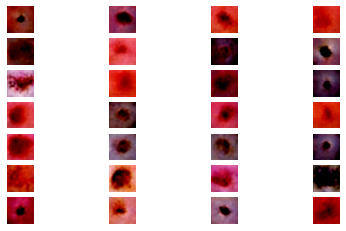

Training GAN at Time Step 1 of Epoch 92
1
************ for time_step 1, discriminator loss is 0.8570523262023926 ***********
******** for time_step 1, generator loss is 1.328570008277893 ***********
Training GAN at Time Step 2 of Epoch 92
1
************ for time_step 2, discriminator loss is 0.90996915102005 ***********
******** for time_step 2, generator loss is 0.9311647415161133 ***********
Training GAN at Time Step 3 of Epoch 92
1
************ for time_step 3, discriminator loss is 1.081847906112671 ***********
******** for time_step 3, generator loss is 1.614127278327942 ***********
Training GAN at Time Step 4 of Epoch 92
1
************ for time_step 4, discriminator loss is 1.0832545757293701 ***********
******** for time_step 4, generator loss is 0.6560776233673096 ***********
Training GAN at Time Step 5 of Epoch 92
1
************ for time_step 5, discriminator loss is 0.9764777421951294 ***********
******** for time_step 5, generator loss is 2.0467112064361572 ***********
Train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

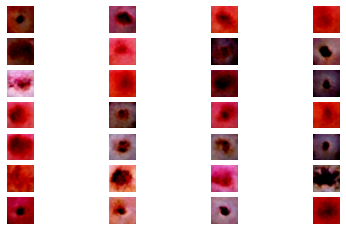

Training GAN at Time Step 1 of Epoch 93
1
************ for time_step 1, discriminator loss is 1.2360856533050537 ***********
******** for time_step 1, generator loss is 0.4971884489059448 ***********
Training GAN at Time Step 2 of Epoch 93
1
************ for time_step 2, discriminator loss is 0.8214495182037354 ***********
******** for time_step 2, generator loss is 1.6279985904693604 ***********
Training GAN at Time Step 3 of Epoch 93
1
************ for time_step 3, discriminator loss is 0.8885676860809326 ***********
******** for time_step 3, generator loss is 1.2470849752426147 ***********
Training GAN at Time Step 4 of Epoch 93
1
************ for time_step 4, discriminator loss is 1.038535475730896 ***********
******** for time_step 4, generator loss is 0.9917261600494385 ***********
Training GAN at Time Step 5 of Epoch 93
1
************ for time_step 5, discriminator loss is 0.9064850211143494 ***********
******** for time_step 5, generator loss is 1.2831469774246216 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

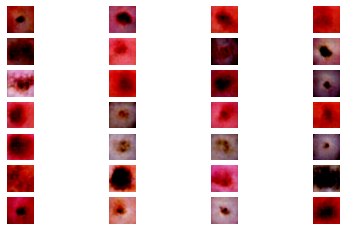

Training GAN at Time Step 1 of Epoch 94
1
************ for time_step 1, discriminator loss is 1.0092320442199707 ***********
******** for time_step 1, generator loss is 1.812400221824646 ***********
Training GAN at Time Step 2 of Epoch 94
1
************ for time_step 2, discriminator loss is 0.8849108815193176 ***********
******** for time_step 2, generator loss is 0.9108285307884216 ***********
Training GAN at Time Step 3 of Epoch 94
1
************ for time_step 3, discriminator loss is 0.8708446025848389 ***********
******** for time_step 3, generator loss is 1.7069685459136963 ***********
Training GAN at Time Step 4 of Epoch 94
1
************ for time_step 4, discriminator loss is 0.8729000687599182 ***********
******** for time_step 4, generator loss is 1.0592881441116333 ***********
Training GAN at Time Step 5 of Epoch 94
1
************ for time_step 5, discriminator loss is 1.0331685543060303 ***********
******** for time_step 5, generator loss is 1.092555046081543 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 94
1
************ for time_step 28, discriminator loss is 1.1142991781234741 ***********
******** for time_step 28, generator loss is 1.032996416091919 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

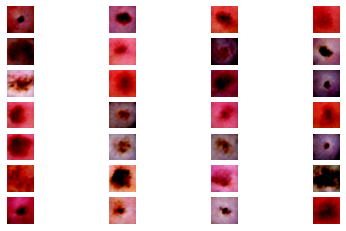

Training GAN at Time Step 1 of Epoch 95
1
************ for time_step 1, discriminator loss is 0.9857378005981445 ***********
******** for time_step 1, generator loss is 1.1773912906646729 ***********
Training GAN at Time Step 2 of Epoch 95
1
************ for time_step 2, discriminator loss is 0.9103343486785889 ***********
******** for time_step 2, generator loss is 1.1225576400756836 ***********
Training GAN at Time Step 3 of Epoch 95
1
************ for time_step 3, discriminator loss is 0.9482933282852173 ***********
******** for time_step 3, generator loss is 1.203986644744873 ***********
Training GAN at Time Step 4 of Epoch 95
1
************ for time_step 4, discriminator loss is 0.9407211542129517 ***********
******** for time_step 4, generator loss is 1.3947370052337646 ***********
Training GAN at Time Step 5 of Epoch 95
1
************ for time_step 5, discriminator loss is 0.9025073051452637 ***********
******** for time_step 5, generator loss is 0.8981894850730896 ***********
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

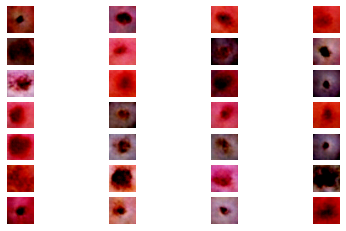

Training GAN at Time Step 1 of Epoch 96
1
************ for time_step 1, discriminator loss is 0.8206804394721985 ***********
******** for time_step 1, generator loss is 1.4471930265426636 ***********
Training GAN at Time Step 2 of Epoch 96
1
************ for time_step 2, discriminator loss is 0.9456128478050232 ***********
******** for time_step 2, generator loss is 1.0588924884796143 ***********
Training GAN at Time Step 3 of Epoch 96
1
************ for time_step 3, discriminator loss is 1.0295469760894775 ***********
******** for time_step 3, generator loss is 1.0625896453857422 ***********
Training GAN at Time Step 4 of Epoch 96
1
************ for time_step 4, discriminator loss is 0.9567049145698547 ***********
******** for time_step 4, generator loss is 1.3521939516067505 ***********
Training GAN at Time Step 5 of Epoch 96
1
************ for time_step 5, discriminator loss is 0.9914527535438538 ***********
******** for time_step 5, generator loss is 0.8709560632705688 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

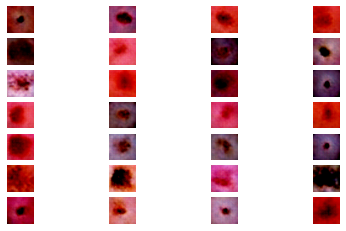

Training GAN at Time Step 1 of Epoch 97
1
************ for time_step 1, discriminator loss is 0.8940087556838989 ***********
******** for time_step 1, generator loss is 1.0124852657318115 ***********
Training GAN at Time Step 2 of Epoch 97
1
************ for time_step 2, discriminator loss is 0.8860365152359009 ***********
******** for time_step 2, generator loss is 1.2482713460922241 ***********
Training GAN at Time Step 3 of Epoch 97
1
************ for time_step 3, discriminator loss is 0.958740234375 ***********
******** for time_step 3, generator loss is 1.2140140533447266 ***********
Training GAN at Time Step 4 of Epoch 97
1
************ for time_step 4, discriminator loss is 0.9523031711578369 ***********
******** for time_step 4, generator loss is 0.9440488815307617 ***********
Training GAN at Time Step 5 of Epoch 97
1
************ for time_step 5, discriminator loss is 1.0851866006851196 ***********
******** for time_step 5, generator loss is 1.469454288482666 ***********
Train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

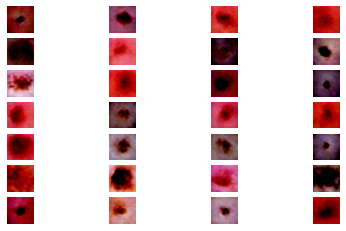

Training GAN at Time Step 1 of Epoch 98
1
************ for time_step 1, discriminator loss is 0.8207683563232422 ***********
******** for time_step 1, generator loss is 1.576430082321167 ***********
Training GAN at Time Step 2 of Epoch 98
1
************ for time_step 2, discriminator loss is 1.0360479354858398 ***********
******** for time_step 2, generator loss is 0.7924675345420837 ***********
Training GAN at Time Step 3 of Epoch 98
1
************ for time_step 3, discriminator loss is 1.3376600742340088 ***********
******** for time_step 3, generator loss is 1.8046791553497314 ***********
Training GAN at Time Step 4 of Epoch 98
1
************ for time_step 4, discriminator loss is 1.6451843976974487 ***********
******** for time_step 4, generator loss is 0.29556477069854736 ***********
Training GAN at Time Step 5 of Epoch 98
1
************ for time_step 5, discriminator loss is 1.4725267887115479 ***********
******** for time_step 5, generator loss is 3.2760367393493652 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

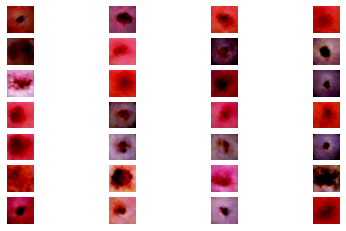

Training GAN at Time Step 1 of Epoch 99
1
************ for time_step 1, discriminator loss is 0.8875689506530762 ***********
******** for time_step 1, generator loss is 0.9660167098045349 ***********
Training GAN at Time Step 2 of Epoch 99
1
************ for time_step 2, discriminator loss is 0.7589017152786255 ***********
******** for time_step 2, generator loss is 1.715683102607727 ***********
Training GAN at Time Step 3 of Epoch 99
1
************ for time_step 3, discriminator loss is 0.7458717823028564 ***********
******** for time_step 3, generator loss is 1.2302227020263672 ***********
Training GAN at Time Step 4 of Epoch 99
1
************ for time_step 4, discriminator loss is 0.822810709476471 ***********
******** for time_step 4, generator loss is 1.2388722896575928 ***********
Training GAN at Time Step 5 of Epoch 99
1
************ for time_step 5, discriminator loss is 1.0567501783370972 ***********
******** for time_step 5, generator loss is 1.0148706436157227 ***********
Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

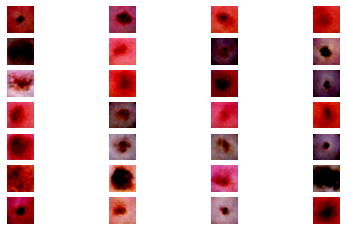

Training GAN at Time Step 1 of Epoch 100
1
************ for time_step 1, discriminator loss is 1.0758612155914307 ***********
******** for time_step 1, generator loss is 0.9669243097305298 ***********
Training GAN at Time Step 2 of Epoch 100
1
************ for time_step 2, discriminator loss is 1.20950186252594 ***********
******** for time_step 2, generator loss is 0.9892705678939819 ***********
Training GAN at Time Step 3 of Epoch 100
1
************ for time_step 3, discriminator loss is 1.1119089126586914 ***********
******** for time_step 3, generator loss is 0.8349531292915344 ***********
Training GAN at Time Step 4 of Epoch 100
1
************ for time_step 4, discriminator loss is 1.0369682312011719 ***********
******** for time_step 4, generator loss is 1.7571676969528198 ***********
Training GAN at Time Step 5 of Epoch 100
1
************ for time_step 5, discriminator loss is 1.027722954750061 ***********
******** for time_step 5, generator loss is 0.6465866565704346 **********

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 100
1
************ for time_step 28, discriminator loss is 1.1064636707305908 ***********
******** for time_step 28, generator loss is 0.8016749620437622 ***********


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

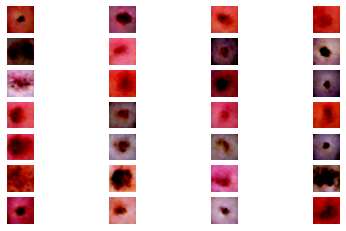

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

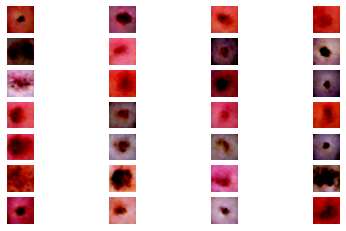

In [ ]:
train_gan(real_imgs_datagen=train_dataset,total_epochs=GAN_epochs)

# Run from here

In [ ]:
# Getting to the checkpoint with minimum loss 
latest_checkpoint_path = tf.train.latest_checkpoint("/content/drive/MyDrive/GAN_training_checkpoints")
latest_checkpoint_path

'/content/drive/MyDrive/GAN_training_checkpoints/ckpt-20'

In [ ]:
GAN_checkpoint.restore(latest_checkpoint_path)

In [ ]:
# Function to generate fake image from Generator, output will go to Discriminator
def generate_and_save_images(generator_model,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

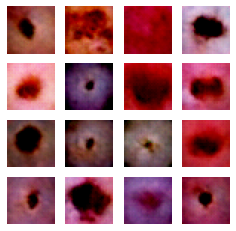

In [ ]:
generate_and_save_images(generator_model=G,test_input=constant_noise)

In [ ]:
# Total images from Unlabeled Folder
unlbld_imgs_base_path = "/content/drive/MyDrive/MelanomaDetection/unlabeled"
imgs_names_list = os.listdir(unlbld_imgs_base_path)
total_imgs = len(imgs_names_list)

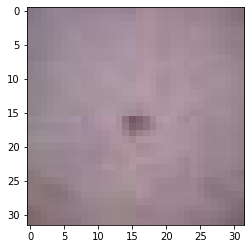

In [ ]:
# Single Real Image
single_img = plt.imread(os.path.join(unlbld_imgs_base_path,imgs_names_list[randint(0,total_imgs-1)]))
plt.imshow(single_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


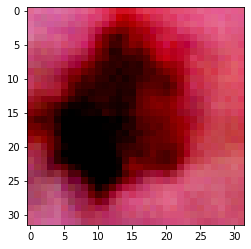

In [ ]:
# Single Fake Image
single_fake_img = G(tf.random.normal(shape=(1,100)))
plt.imshow(single_fake_img[0,:,:,:])

In [ ]:
# Function to create a discriminator base
def discriminator_base():

  input_to_cls = Input(shape=(32,32,3))

  disc_base = Sequential(name="disc_base")
  disc_base.add(input_to_cls)

  for layer in D.layers[0:10]:
    disc_base.add(layer)

  return disc_base

In [ ]:
# Now we will define 2 classifiers in Discriminator Base - Supervised and Unsupervised
def unsupervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

def supervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

In [ ]:
# Object for both classifiers
unsupervised_cls = unsupervised_classifier()
supervised_cls = supervised_classifier()

In [ ]:
# Optimizersfor both cls - to optimize the classifier to get minimum loss
unsupervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.3)
supervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.3)

In [ ]:
# Object to calculate accuracy metrics of supervised classifier
supervised_cls_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
supervised_cls_cv_acc_metric = tf.keras.metrics.BinaryAccuracy()
supervised_cls_test_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [ ]:
# Function to calculate the Loss of Unsupervised Classifier
def unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = tf.ones_like(real_imgs_preds)
  fake_imgs_labels = tf.zeros_like(fake_imgs_preds)

  real_imgs_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_loss + fake_imgs_loss

  return total_loss

def supervised_cls_loss(imgs_labels,imgs_preds):

  return bce_loss(y_true=imgs_labels,y_pred=imgs_preds)

In [ ]:
# Semi supervised training 
@tf.function
def ssl_training_step(labeled_images,unlabeled_images):

  G.trainable = False
  unsupervised_cls.trainable = True
  supervised_cls.trainable = True

  with tf.GradientTape() as supervised_cls_tape, tf.GradientTape() as unsupervised_cls_tape, tf.GradientTape() as gen_tape:

    labeled_imgs_preds = supervised_cls(labeled_images[0],training=True)
    
    supervised_loss = supervised_cls_loss(imgs_labels=labeled_images[1],imgs_preds=labeled_imgs_preds)

    gradients_of_supervised_cls = supervised_cls_tape.gradient(supervised_loss,supervised_cls.trainable_variables)
    supervised_cls_optimizer.apply_gradients(zip(gradients_of_supervised_cls,supervised_cls.trainable_variables))

    noise = tf.random.normal(shape=(batch_size,noise_shape))
    generated_images = G(noise,training=False)

    real_imgs_preds = unsupervised_cls(unlabeled_images,training=True)
    fake_imgs_preds = unsupervised_cls(generated_images,training=True)

    unsupervised_loss = unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds)

    gradients_of_unsupervised_cls = unsupervised_cls_tape.gradient(unsupervised_loss,unsupervised_cls.trainable_variables)
    unsupervised_cls_optimizer.apply_gradients(zip(gradients_of_unsupervised_cls,unsupervised_cls.trainable_variables))

    # supervised_cls.trainable = False
    # unsupervised_cls.trainable = False

  return supervised_loss,labeled_imgs_preds

In [ ]:
# creating subfolder for training data

train_dir = '/content/drive/MyDrive/MelanomaDetection/labeled'
zero_labeled_folder = os.path.join(train_dir,'zero_labeled_folder')
one_labeled_folder = os.path.join(train_dir,'one_labeled_folder')
os.mkdir(one_labeled_folder)
os.mkdir(zero_labeled_folder)
labeled_data_path = "/content/drive/MyDrive/MelanomaDetection/labeled"

for img_filename in os.listdir(labeled_data_path):
  if img_filename.endswith("0.jpg"):
    shutil.move(os.path.join(train_dir,img_filename),os.path.join(zero_labeled_folder,img_filename))

  elif img_filename.endswith("1.jpg"):
    shutil.move(os.path.join(train_dir,img_filename),os.path.join(one_labeled_folder,img_filename))

In [ ]:
# creating subfolder for testing_data

test_dir = '/content/drive/MyDrive/MelanomaDetection/test'
zero_test_folder = os.path.join(test_dir,'zero_test_folder')
one_test_folder = os.path.join(test_dir,'one_test_folder')
os.mkdir(one_test_folder)
os.mkdir(zero_test_folder)
test_data_path = "/content/drive/MyDrive/MelanomaDetection/test"

for img_filename in os.listdir(test_data_path):
  if img_filename.endswith("0.jpg"):
    shutil.move(os.path.join(test_dir,img_filename),os.path.join(zero_test_folder,img_filename))

  elif img_filename.endswith("1.jpg"):
    shutil.move(os.path.join(test_dir,img_filename),os.path.join(one_test_folder,img_filename))

In [ ]:
cls_checkpoint_dir = "/content/drive/MyDrive/pure_supervised_cls_checkpoints_melanoma"
checkpoint_prefix = os.path.join(cls_checkpoint_dir,"ckpt")
cls_checkpoint = tf.train.Checkpoint(optimizer=[supervised_cls_optimizer,unsupervised_cls_optimizer],
                                     model=[supervised_cls,unsupervised_cls])

In [ ]:
cls_epochs = 200

In [ ]:
cv_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)
cv_datagen = cv_data_gen.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection/test",
                                             target_size=(32,32),
                                             classes=os.listdir("/content/drive/MyDrive/MelanomaDetection/test"),
                                             class_mode="binary",batch_size=150)

Found 600 images belonging to 2 classes.


In [ ]:
labeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)
labeled_datagen = labeled_data_gen.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection/labeled",
                                                       target_size=(32,32),
                                                       classes=os.listdir("/content/drive/MyDrive/MelanomaDetection/labeled"),
                                                       class_mode="binary",batch_size=7)

Found 200 images belonging to 2 classes.


In [ ]:
def train_ssl_classifier(labeled_imgs_datagen,unlabeled_imgs_datagen,cv_imgs_datagen,total_epochs):

  for epoch in range(total_epochs):

    time_step = 1

    for labeled_images_batch, unlabeled_images_batch in zip(labeled_imgs_datagen,unlabeled_imgs_datagen):

      supervised_loss, labeled_imgs_preds = ssl_training_step(labeled_images=labeled_images_batch,unlabeled_images=unlabeled_images_batch[0])

      if time_step > len(os.listdir("/content/drive/MyDrive/MelanomaDetection/unlabeled"))//batch_size:
        break

      supervised_cls_train_acc_metric.update_state(labeled_images_batch[1],labeled_imgs_preds)
      print("Training Loss at Time Step {} of Epoch {} is {}".format(time_step,epoch+1,float(supervised_loss)))

      time_step = time_step + 1

    training_accuracy = supervised_cls_train_acc_metric.result()
    print("\nTraining Accuracy after Epoch {} is {}".format(epoch+1,float(training_accuracy)))

    supervised_cls_train_acc_metric.reset_states()

    cv_time_steps = 0

    for X_cv,Y_cv_labels in cv_imgs_datagen:

      if cv_time_steps > 300//150:
        break

      cv_time_steps = cv_time_steps + 1

      Y_cv_preds = supervised_cls(X_cv,training=False)
      supervised_cls_cv_acc_metric.update_state(Y_cv_labels,Y_cv_preds)

    cv_accuracy = supervised_cls_cv_acc_metric.result()
    print("Cross Validation Accuracy after Epoch {} is {}\n".format(epoch+1,float(cv_accuracy)))

    supervised_cls_cv_acc_metric.reset_states()

    cls_checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
train_ssl_classifier(labeled_imgs_datagen=labeled_datagen,unlabeled_imgs_datagen=unlabeled_datagen,
                     cv_imgs_datagen=cv_datagen,total_epochs=cls_epochs)

Training Loss at Time Step 1 of Epoch 1 is 0.5325762629508972
Training Loss at Time Step 2 of Epoch 1 is 0.5858729481697083
Training Loss at Time Step 3 of Epoch 1 is 0.5835835337638855
Training Loss at Time Step 4 of Epoch 1 is 0.7202624082565308
Training Loss at Time Step 5 of Epoch 1 is 0.6701450943946838
Training Loss at Time Step 6 of Epoch 1 is 0.6428291201591492
Training Loss at Time Step 7 of Epoch 1 is 0.48743680119514465
Training Loss at Time Step 8 of Epoch 1 is 0.530311644077301
Training Loss at Time Step 9 of Epoch 1 is 0.6697406768798828
Training Loss at Time Step 10 of Epoch 1 is 0.5024703145027161
Training Loss at Time Step 11 of Epoch 1 is 0.5691837668418884
Training Loss at Time Step 12 of Epoch 1 is 0.6402907371520996
Training Loss at Time Step 13 of Epoch 1 is 0.5675987005233765
Training Loss at Time Step 14 of Epoch 1 is 0.741529643535614
Training Loss at Time Step 15 of Epoch 1 is 0.5325056910514832
Training Loss at Time Step 16 of Epoch 1 is 0.5323989987373352
Tr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Streaming output truncated to the last 5000 lines.
Training Loss at Time Step 23 of Epoch 39 is 0.585020899772644
Training Loss at Time Step 24 of Epoch 39 is 0.7790541648864746
Training Loss at Time Step 25 of Epoch 39 is 0.6331149339675903
Training Loss at Time Step 26 of Epoch 39 is 0.4240933358669281
Training Loss at Time Step 27 of Epoch 39 is 0.5759521126747131

Training Accuracy after Epoch 39 is 0.7539681196212769
Cross Validation Accuracy after Epoch 39 is 0.7155556082725525

Training Loss at Time Step 1 of Epoch 40 is 0.6087265610694885
Training Loss at Time Step 2 of Epoch 40 is 0.5340890884399414
Training Loss at Time Step 3 of Epoch 40 is 0.698024570941925
Training Loss at Time Step 4 of Epoch 40 is 0.6454796195030212
Training Loss at Time Step 5 of Epoch 40 is 0.551534116268158
Training Loss at Time Step 6 of Epoch 40 is 0.5546637177467346
Training Loss at Time Step 7 of Epoch 40 is 0.47617489099502563
Training Loss at Time Step 8 of Epoch 40 is 0.7894080877304077
Trainin

In [ ]:
 test_data_generator = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)

In [ ]:
test_datagen = test_data_generator.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection/test",
                                                        target_size=(32,32),
                                                       classes=os.listdir("/content/drive/MyDrive/MelanomaDetection/test"),
                                                       class_mode="binary",batch_size=600)

Found 600 images belonging to 2 classes.


In [ ]:
test_pred = supervised_cls(test_datagen[0][0])

In [ ]:
supervised_cls_test_acc_metric.update_state(test_datagen[0][1],test_pred)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [ ]:
float(supervised_cls_test_acc_metric.result())

0.6416666507720947